In [1]:
import xarray as xr 
import cmocean 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import cftime
import numpy as np

In [2]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6

## Assessment of Geostrophic Balance
This dataset contains:
- sea surface height (SSH --> zos) (referenced to a global mean of zero)
- zonal (u --> uo) and meridional (v --> vo) velocities 
at daily temporal resolution.


Goal is to assess the accuracy of the geostrophic balance approximation:
- step: horizontal gradient estimation (dh/dx, dh/dy --> convert lat/lon to distance) 
- step: geostrophic velocity estimation (leverage the geostrophic balance relationship to find geostrophic velocities u_g, v_g)
- step: calculate difference between surface velocities (uo,vo) and surface geostrophic velocities (difference between u and u_g, v and v_g)


Questions to address/explore:
- question 1: consider and plot differences between u_g and uo, v_g and vo as a function of timescale (e.g. using a single time slice vs. a long time mean)
- question 2: how sensitive are results to the length scale over which a gradient is calculated? (remember velocities have to be averaged across the same length scale). Choose a second length scale to compute gradient and estimate velocity difference (think of center difference methods and/or linear slope fitting)
- question 3: compute relative vorticity at a single time slice and for the time mean

Geostrophic balance is the relationship between the coriolis force and the pressure gradient force. 

so is salinity   
thetao is potential temperature   
uo is the u velocity   
vo is the v velocity   
zos is sea surface height   

In [3]:
glorys_jan_mar_2021 = xr.open_zarr('../data/glorys_jan_mar_2021_daily_surface') # Defining the dataset to use in this notebook

In [4]:
print(glorys_jan_mar_2021) # Printing the dataset, there's multiple coordinates and data variables to consider

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 385, longitude: 950, time: 90)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 19.25 19.33 19.42 19.5 ... 51.08 51.17 51.25
  * longitude  (longitude) float32 -87.25 -87.17 -87.08 ... -8.333 -8.25 -8.167
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-03-31
Data variables:
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(12, 97, 238), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    comment:  

In [5]:
uo = glorys_jan_mar_2021['uo'] # Defining "uo" as the uo in the dataset. Uo is the u velocity

In [6]:
vo = glorys_jan_mar_2021['vo'] # Defining "vo" as the vo in the dataset. Vo is the v velocity 

To calculate delta x and delta y in meters the equations are used below:   
change in x = 1,852 x 60 x cos(lat) x (lon2 - lon1)   
change in y = 1,852 x 60 x (lat2 -lat1)

In [7]:
def changex (lat, lon1, lon2):
    'This function returns the dx (delta x) value in meters. The variables needed are latitude, the first longitude value, and the second longitude value'
    x =  1852 * 60 * np.cos(np.deg2rad(lat)) * (lon2 - lon1)
    return x

In [8]:
def changey (lat1, lat2):
    'This function returns the dy (delta y) value in meters. The variables needed are the first latitude and the second latitude.'
    y = 1852 * 60 * (lat2-lat1)
    return y

The following cells run through an example finding the dx and dy values the long way with the equations, and then with the functions.

In [9]:
ex_dx = 1852 * 60 * np.cos(np.deg2rad(19.25)) * (-87.17 - -87.25)

In [10]:
ex_dx # The units are meters

8392.573755683516

In [11]:
ex_dy = 1852 * 60 * (19.33 - 19.25)

In [12]:
ex_dy # The units are meters

8889.599999999811

In [13]:
func_ex_dx = changex(19.25, -87.25, -87.17)

In [14]:
func_ex_dx # The units are meters 

8392.573755683516

In [15]:
func_ex_dy = changey(-87.25, -87.17)

In [16]:
func_ex_dy # The units are meters

8889.599999999811

In [17]:
glorys_jan_mar_2021.zos # Looking at the sea surface height array (zos) and its coordinates. There's longitude, latitude, and time.

<xarray.DataArray 'zos' (time: 90, latitude: 385, longitude: 950)>
dask.array<open_dataset-zos, shape=(90, 385, 950), dtype=float32, chunksize=(12, 97, 238), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 19.25 19.33 19.42 19.5 ... 51.08 51.17 51.25
  * longitude  (longitude) float32 -87.25 -87.17 -87.08 ... -8.333 -8.25 -8.167
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-03-31
Attributes:
    cell_methods:   area: mean
    long_name:      Sea surface height
    standard_name:  sea_surface_height_above_geoid
    unit_long:      Meters
    units:          m
    valid_max:      1.7346720695495605
    valid_min:      -1.9006928205490112

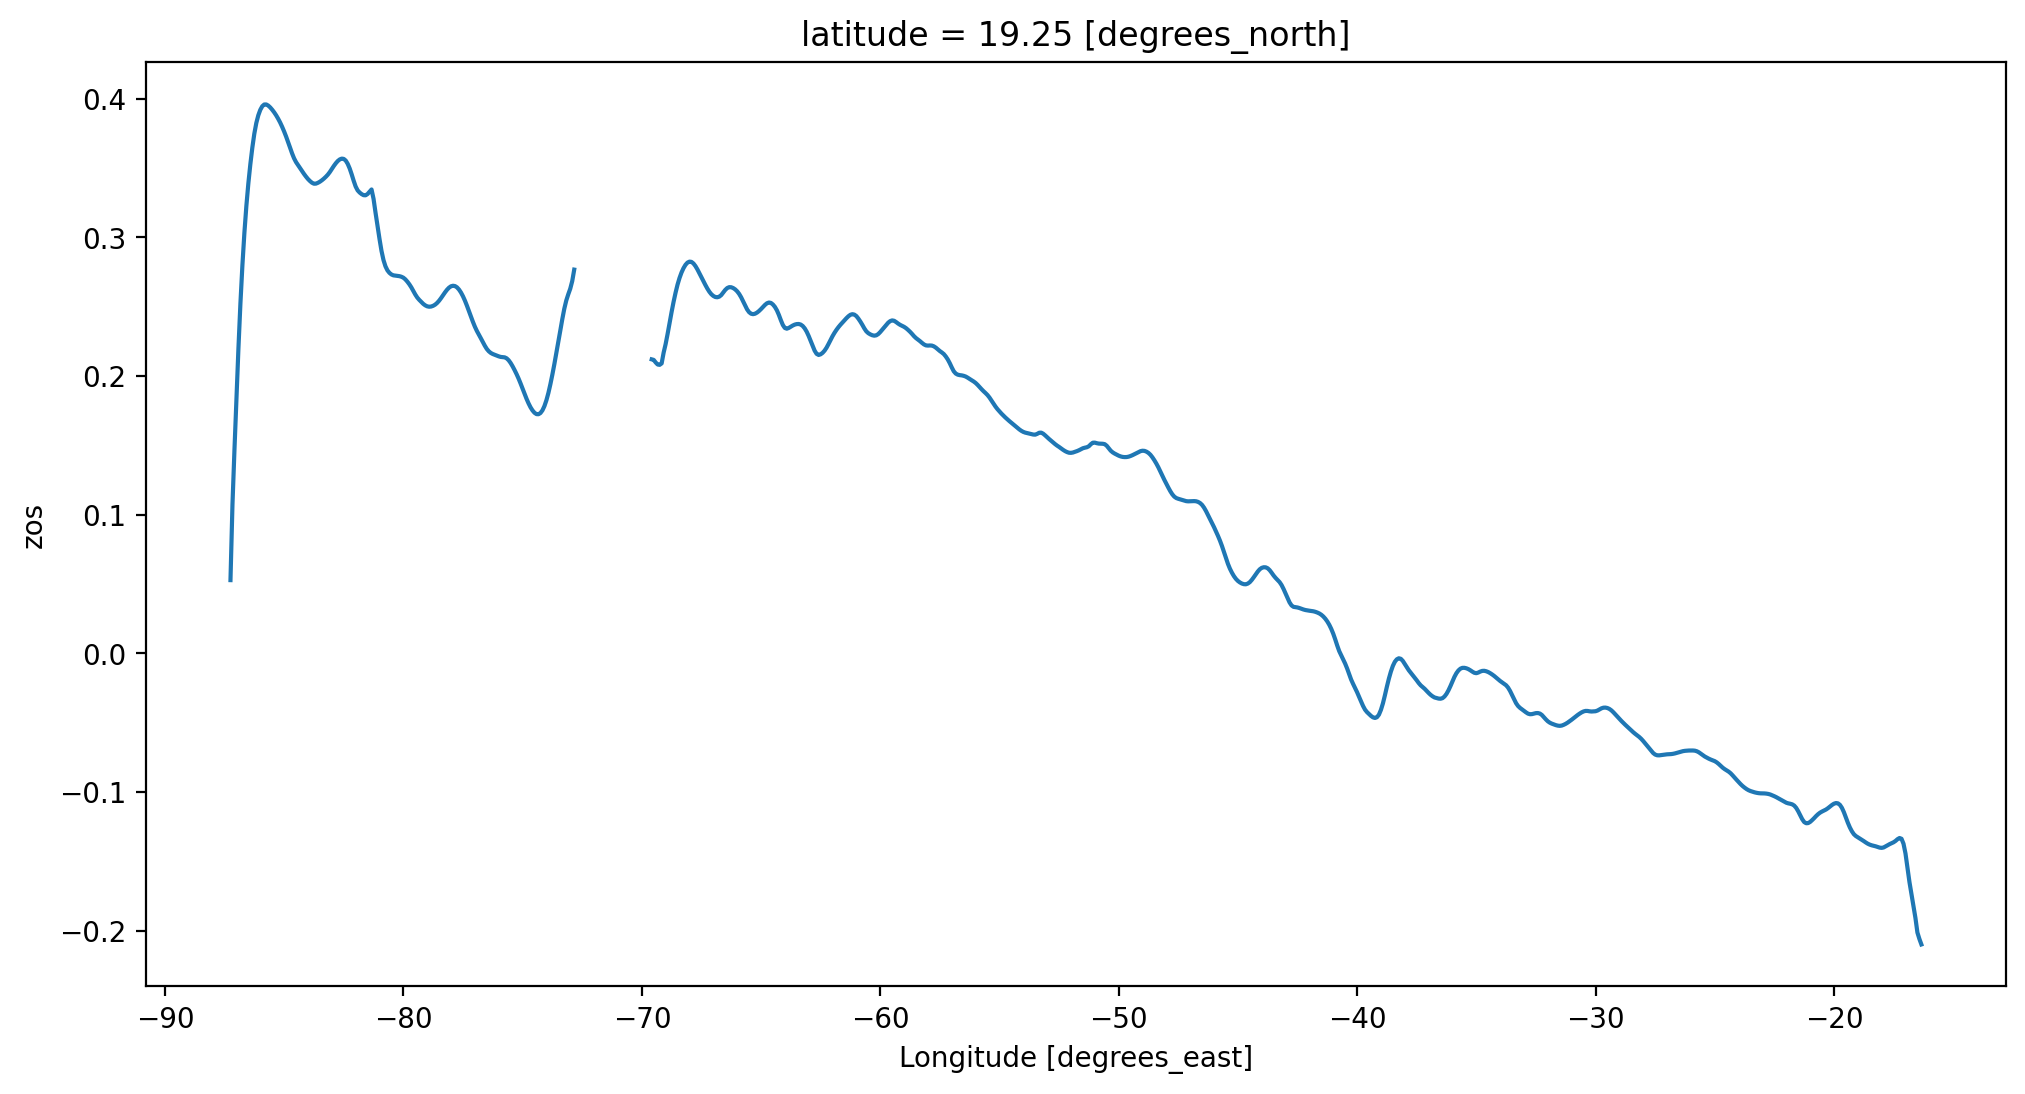

In [18]:
glorys_jan_mar_2021.zos.mean(dim='time').isel(latitude=0).plot()  # This is a plot of the zos values across all longitudes for a single latitude value.
# First, a mean of the "time" coordinate needs to be taken to exclude it from the plot since we are only considering the latitude and longitude.
# Then .isel was used to select all of the zos values across all longitudes for the first latitude value (input as 0 since the index starts at 0).
# .plot() was used to plot this below.

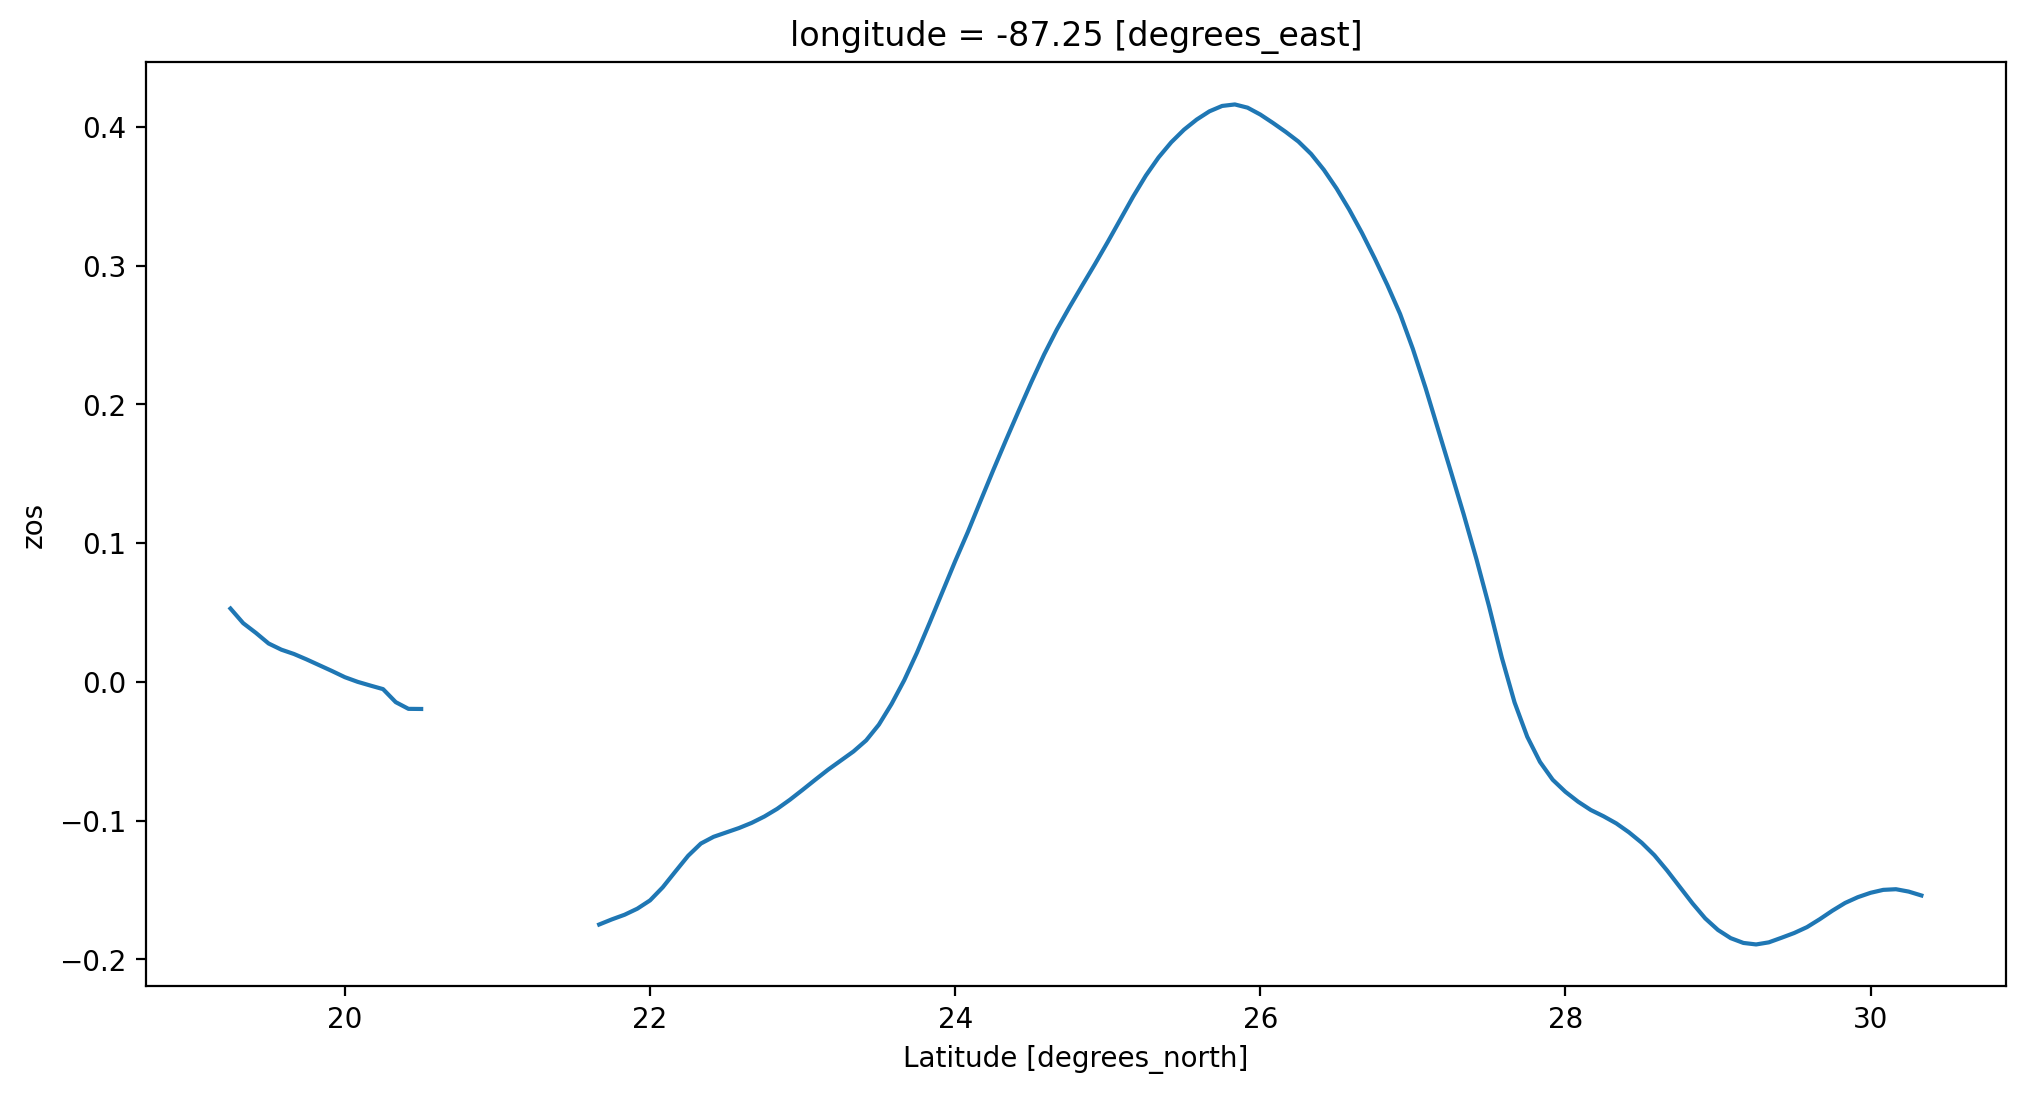

In [19]:
glorys_jan_mar_2021.zos.mean(dim='time').isel(longitude=0).plot()  # This is a plot of the zos values across all latitudes for a single longitude value.
# First, a mean of the "time" coordinate needs to be taken to exclude it from the plot since we are only considering the latitude and longitude.
# Then .isel was used to select all of the zos values across all latitudes for the first longitude value (input as 0 since the index starts at 0).
# .plot() was used to plot this below.

In [20]:
x=glorys_jan_mar_2021.zos.longitude # Defining x as the zos values at the longitude coordinate
h=glorys_jan_mar_2021.zos # Defining h as the zos values
y=glorys_jan_mar_2021.zos.latitude # Defining y as the zos values at the latitude coordinate

The following cells are showing examples of dx and dy using the arrays and converting them both to meters. An example of dh and the slope of a section of dh is also shown.

In [21]:
ex_dx = x.isel(longitude=1)-x.isel(longitude=0) # This is an example of dx, but it's not in meters. This is the difference between the first and second 
# longitude values in x which was previously defined.
ex_dx.values # This is a way to show the values in an array, so it is showing the value of the ex_dx array defined above.

array(0.08332825, dtype=float32)

In [22]:
ex_dx1=changex(y.isel(latitude=0).values, x.isel(longitude=0).values, x.isel(longitude=1).values) # This is converting the above dx value into meters using the function
ex_dx1

8741.730512473805

In [23]:
ex_dy = y.isel(latitude=1)-y.isel(latitude=0) # This is an example of dy, but it's not in meters. This is the difference between the first and 
# Second latitude values in y which was previously defined. 
ex_dy.values # This is showing the values in the array

array(0.08333397, dtype=float32)

In [24]:
ex_dy1 = changey(y.isel(latitude=0).values, y.isel(latitude=1).values) # This is converting the dy value into meters using the function
ex_dy1

9260.07064819336

In [25]:
ex_dh = h.mean(dim='time').isel(latitude=1).isel(longitude=1)-h.mean(dim='time').isel(latitude=0).isel(longitude=0) # Finding dh between the first and second latitude and longitude values
ex_dh.values

array(0.0428446, dtype=float32)

In [26]:
ex_slope = ex_dh/ex_dx1 # This is calculating the slope of the sea surface height 
ex_slope.values

array(4.9011583e-06, dtype=float32)

In [27]:
def compute_dx(zos): # Defining the function "compute_dx" which requires zos as the parameter 
    
    lons = zos.coords['longitude'].values # Gathering the longitude values from the coordinate part of zos
    lats = zos.coords['latitude'].values # Gathering the latitude values from the coordinate part of zos
    
    dx_values = [] # Creates an empty list to store the dx values for each latitude
    
    
    for lat in lats: # Creates a four loop over each latitude to calculate the dx values
        dx_lat = []  # Creates an empty list to store dx values for this latitude
        for i in range(len(lons) - 1):
            lon1 = lons[i]
            lon2 = lons[i + 1]
            dx = changex(lat, lon1, lon2) # Calls the function changex to use the lat, lon1, and lon2 values
            dx_lat.append(dx) # This adds the dx values to the dx_lat list
        dx_values.append(dx_lat) # This adds the dx_lat values to the dx_values list
    
    return np.array(dx_values) # Returns the dx values as an array

In [28]:
example_dx = compute_dx(glorys_jan_mar_2021.zos) # Calling the function above and inputing the zos xarray

In [29]:
example_dx

array([[8741.73051247, 8742.53089066, 8742.53089066, ..., 8742.23074884,
        8742.23074884, 8742.33079611],
       [8737.28160367, 8738.08157451, 8738.08157451, ..., 8737.78158545,
        8737.78158545, 8737.8815818 ],
       [8732.81393008, 8733.61349187, 8733.61349187, ..., 8733.3136562 ,
        8733.3136562 , 8733.41360142],
       ...,
       [5816.67866096, 5817.2112263 , 5817.2112263 , ..., 5817.0115143 ,
        5817.0115143 , 5817.07808496],
       [5806.19411554, 5806.72572093, 5806.72572093, ..., 5806.52636891,
        5806.52636891, 5806.59281958],
       [5795.6974282 , 5796.22807254, 5796.22807254, ..., 5796.02908091,
        5796.02908091, 5796.09541145]])

In [30]:
def compute_dy(zos): #Defining the function "compute_dy" which requires zos as a parameter 
    
    lons = zos.coords['longitude'].values # Gathering the longitude values from the coordinate part of zos
    lats = zos.coords['latitude'].values # Gathering the latitude values from the coordinate part of zos
    
    dy_values = [] # Creates an empty list to store the dy values for each longitude
    
    for lon in lons: # Creates a four loop over each longitude to calculate the dy values
        dy_lon = []  # Creates a list to store the dy values for this longitude
        for i in range(len(lats) - 1):
            lat1 = lats[i]
            lat2 = lats[i + 1]
            dy = changey(lat1, lat2) # Calls the function changey to use the lat1 and lat2 values
            dy_lon.append(dy) # This adds the dy values to the dy_lon list
        dy_values.append(dy_lon) # This adds the dy_lon values to the dy_values list
    
    return np.array(dy_values) # Returns the dy values as an array

In [31]:
example_dy = compute_dy(glorys_jan_mar_2021.zos) # Calling the function above and inputing the zos xarray

In [32]:
example_dy

array([[9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       ...,
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361]])

In [33]:
zos = xr.DataArray(glorys_jan_mar_2021.zos.mean(dim='time'))  # Defining zos and exluding the time by taking the mean

zos_sliced = zos.isel(longitude=slice(0, 384))  # Slicing the zos data to match coordinate dimension of the latitude coordinates since the dimensions of longitude are larger

dx_values = compute_dx(zos_sliced) # Computing dx with the sliced data using the compute_dx function
dy_values = compute_dy(zos_sliced) # Computing dy with the sliced data using the compute_dy function

dx_xr = xr.DataArray(dx_values, # This is defining the xarrays with the coordinates as the sliced values
                     coords=[zos_sliced.coords['latitude'], zos_sliced.coords['longitude'][:-1]], 
                     dims=["latitude", "longitude"])

dy_xr = xr.DataArray(dy_values, 
                     coords=[zos_sliced.coords['latitude'][:-1], zos_sliced.coords['longitude']], 
                     dims=["latitude", "longitude"])

In [34]:
dh_lon = h.diff('longitude') # Finding the dh for the longitudes
dx_xr1 = dx_values[384, 383-1] # Slicing the dx values in the proper dimensions 
grad_lon = dh_lon / dx_xr1 # Finding the dh/dx gradient

In [35]:
dh_lat = h.diff('latitude') # Finding the dh for the latitudes
dy_xr1 = dy_values[383, 383-1] # Slicing the dy values in the proper dimensions
grad_lat = dh_lat / dy_xr1 # Finding the dh/dy gradient

In [36]:
dy_slice = example_dy[0:383] # Slicing the dy values to match the correct dimensions

In [37]:
dy_slice

array([[9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       ...,
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361],
       [9260.07064819, 9259.85870361, 9260.07064819, ..., 9259.85870361,
        9260.28259277, 9259.85870361]])

In [38]:
grad_lon_slice = grad_lon.isel(latitude=slice(0, 383), longitude=slice(0, 384)) # Slicing the dh/dx gradient to the correct dimensions

In [39]:
grad_lat_slice = grad_lat.isel(latitude=slice(0, 383), longitude=slice(0, 384)) # Slicing the dh?dy gradient to the correct dimensions

In [40]:
def total_velocity(latitude, gradient, velocity='vg'): # Creating a function "total_velocity" that requires the latitude, gradient, and units
    if velocity == 'vg' : # If the units are vg then use the equation below, this equation utilizes the Coriolis value f
        total_v = (9.8 * gradient)/(2 * 7.2921e-5 * np.sin(latitude))
    if velocity == 'ug' : # If the units are ug then use the equation below, this equation utilizes the Coriolis value f
        total_v = (-9.8 * gradient)/(2 * 7.2921e-5 * np.sin(latitude))
    
    return total_v

In [41]:
vg = total_velocity(dy_slice, grad_lon_slice, velocity='vg') # Calling the function to determine the vg values

In [42]:
ug = total_velocity(dy_slice, grad_lat_slice, velocity='ug') # Calling the function to determine the ug values

In [70]:
uo_time0 = glorys_jan_mar_2021.uo.isel(time=0)

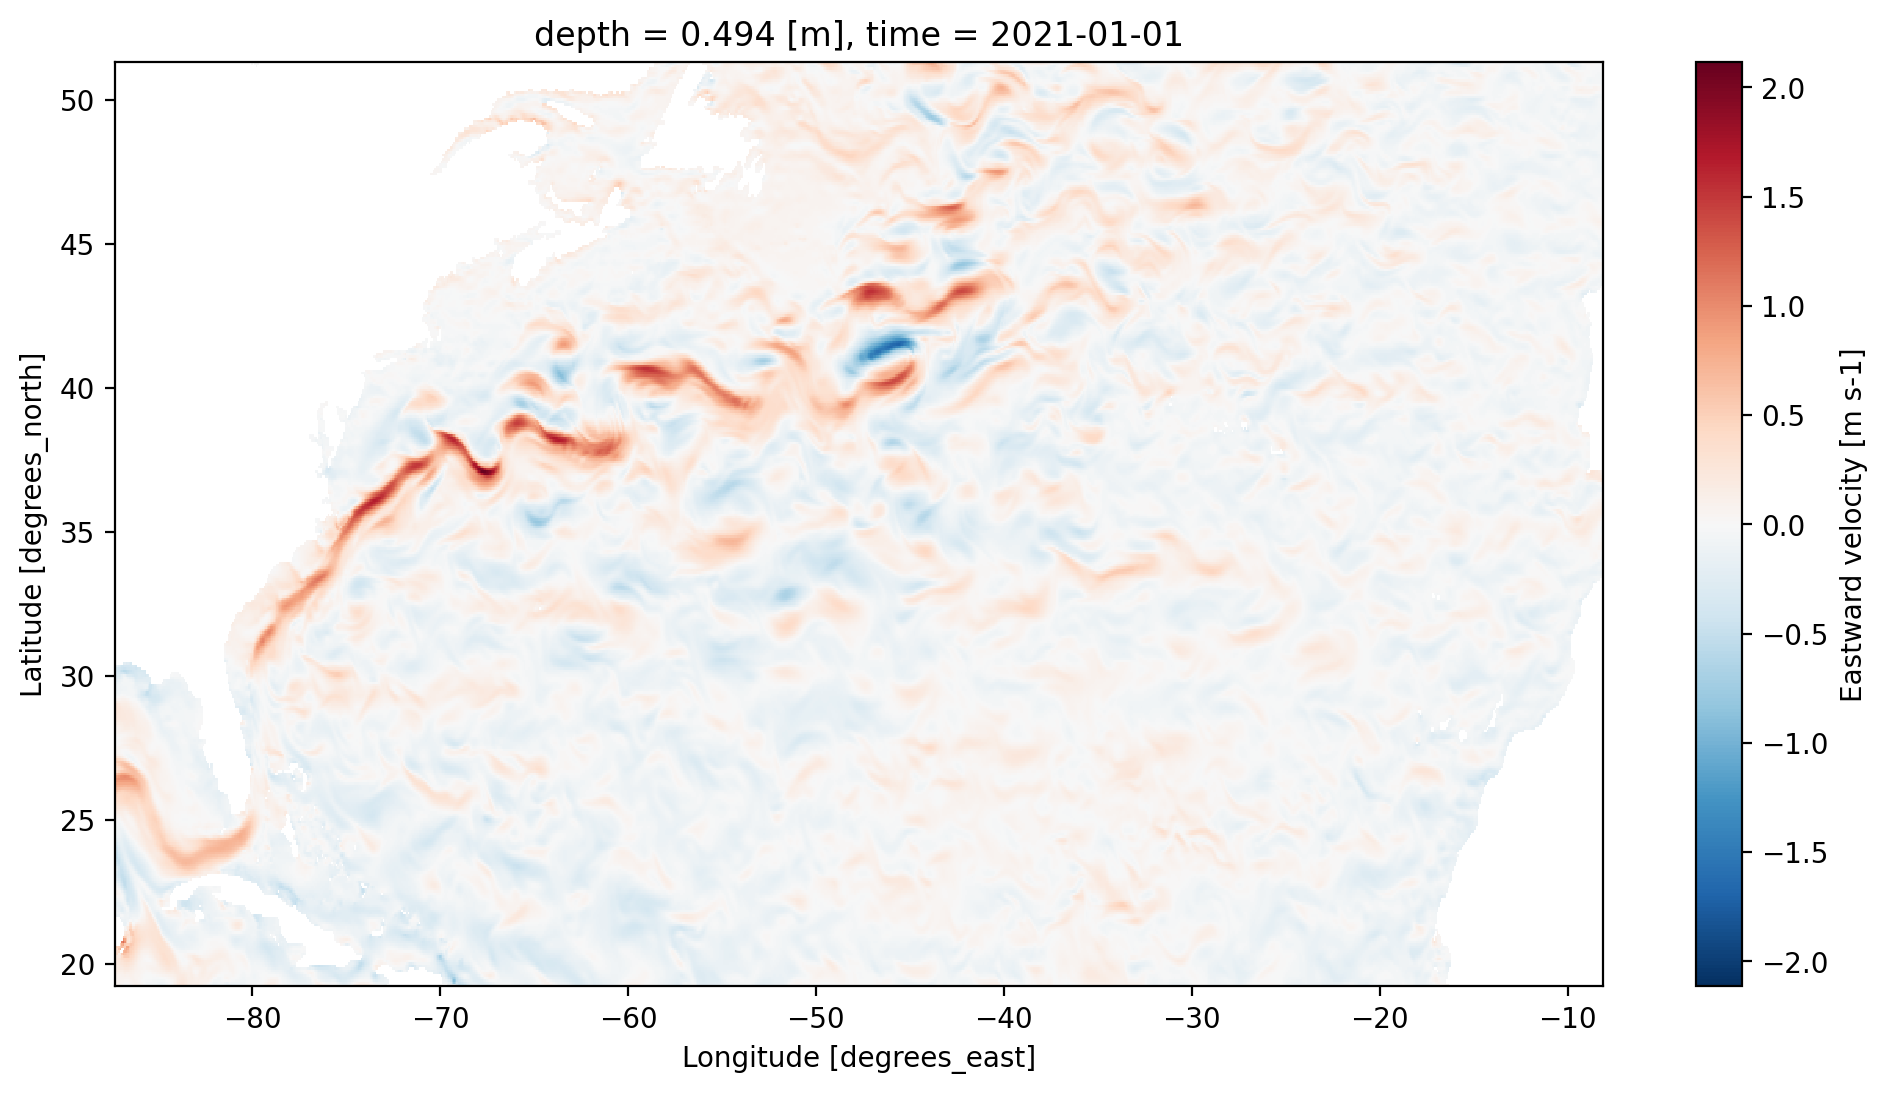

In [71]:
glorys_jan_mar_2021.uo.isel(time=0).plot() # Plotting the uo values from the dataset at a singular time value

In [72]:
vo_time0 = glorys_jan_mar_2021.vo.isel(time=0)

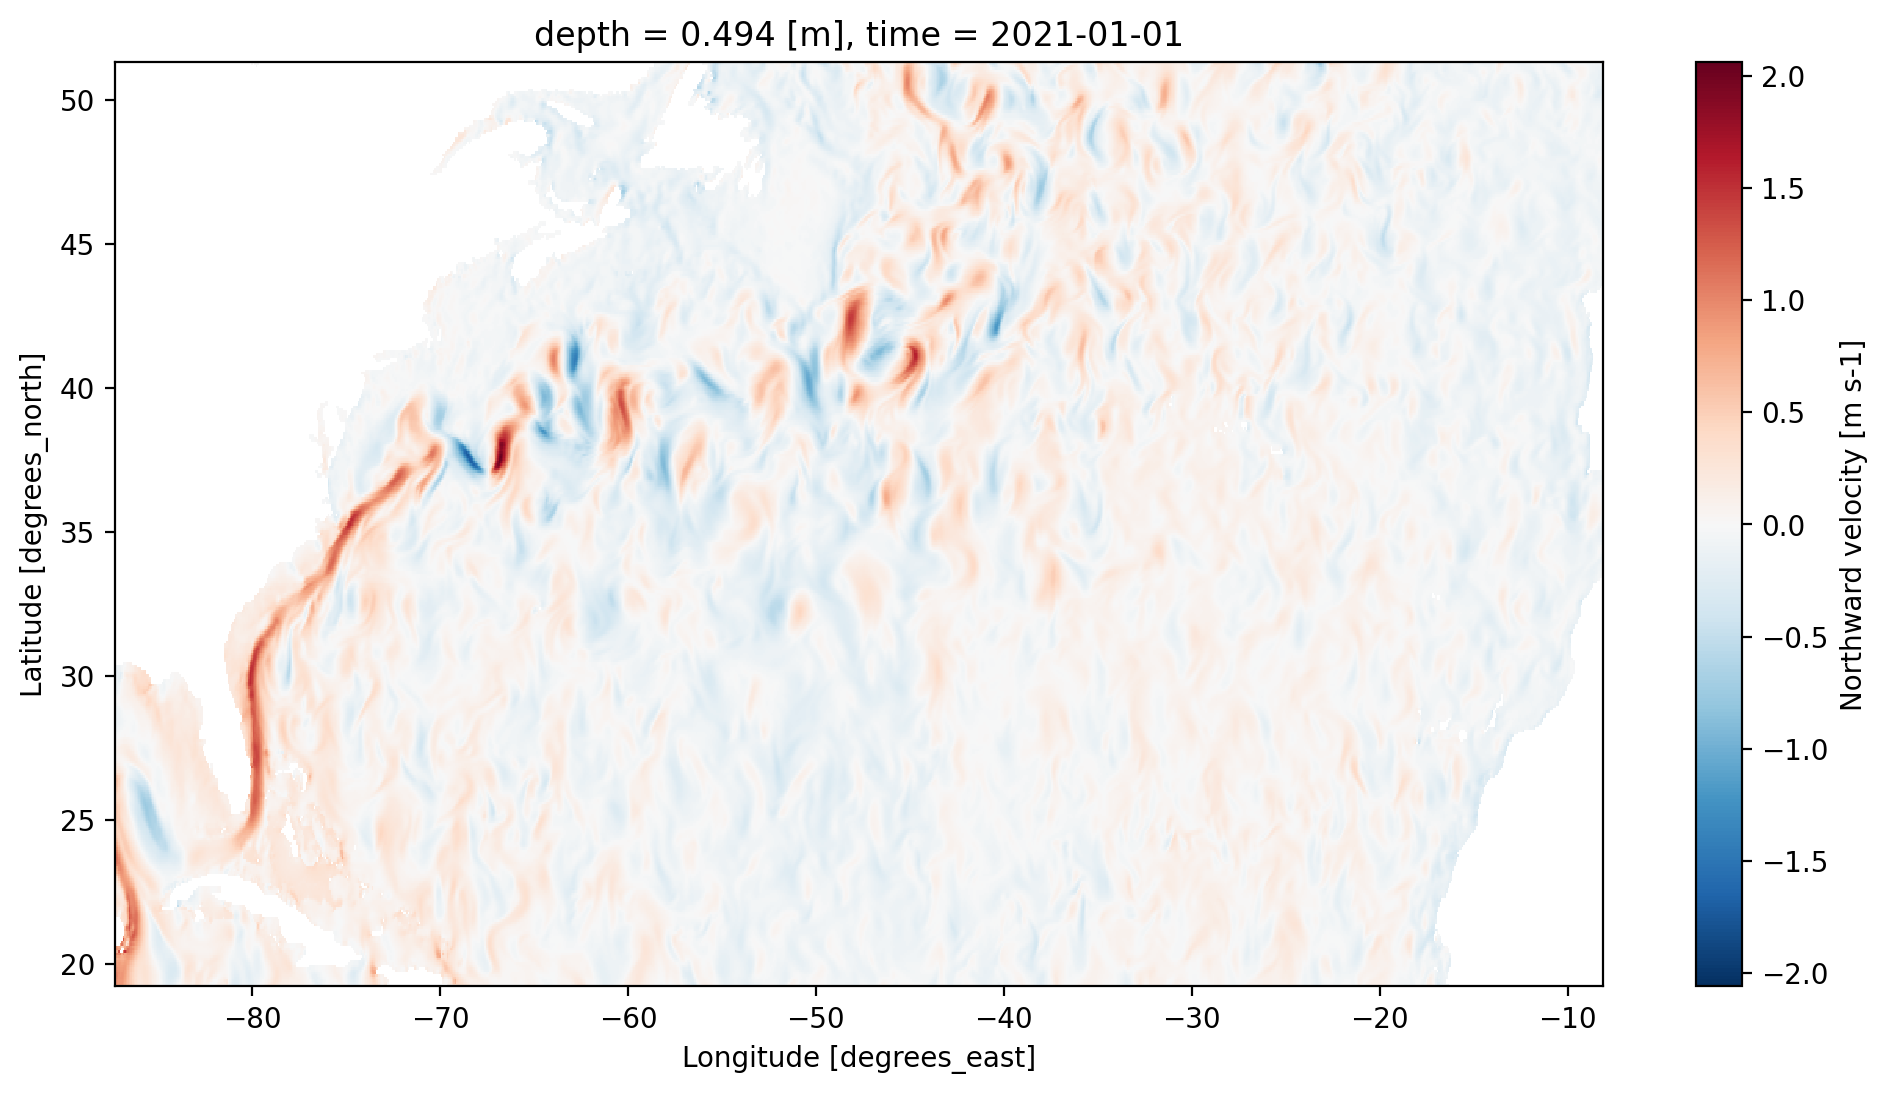

In [73]:
glorys_jan_mar_2021.vo.isel(time=0).plot() # Plotting the vo values from the dataset at a singluar time value

In [74]:
ug_time0 = ug.isel(time=0)

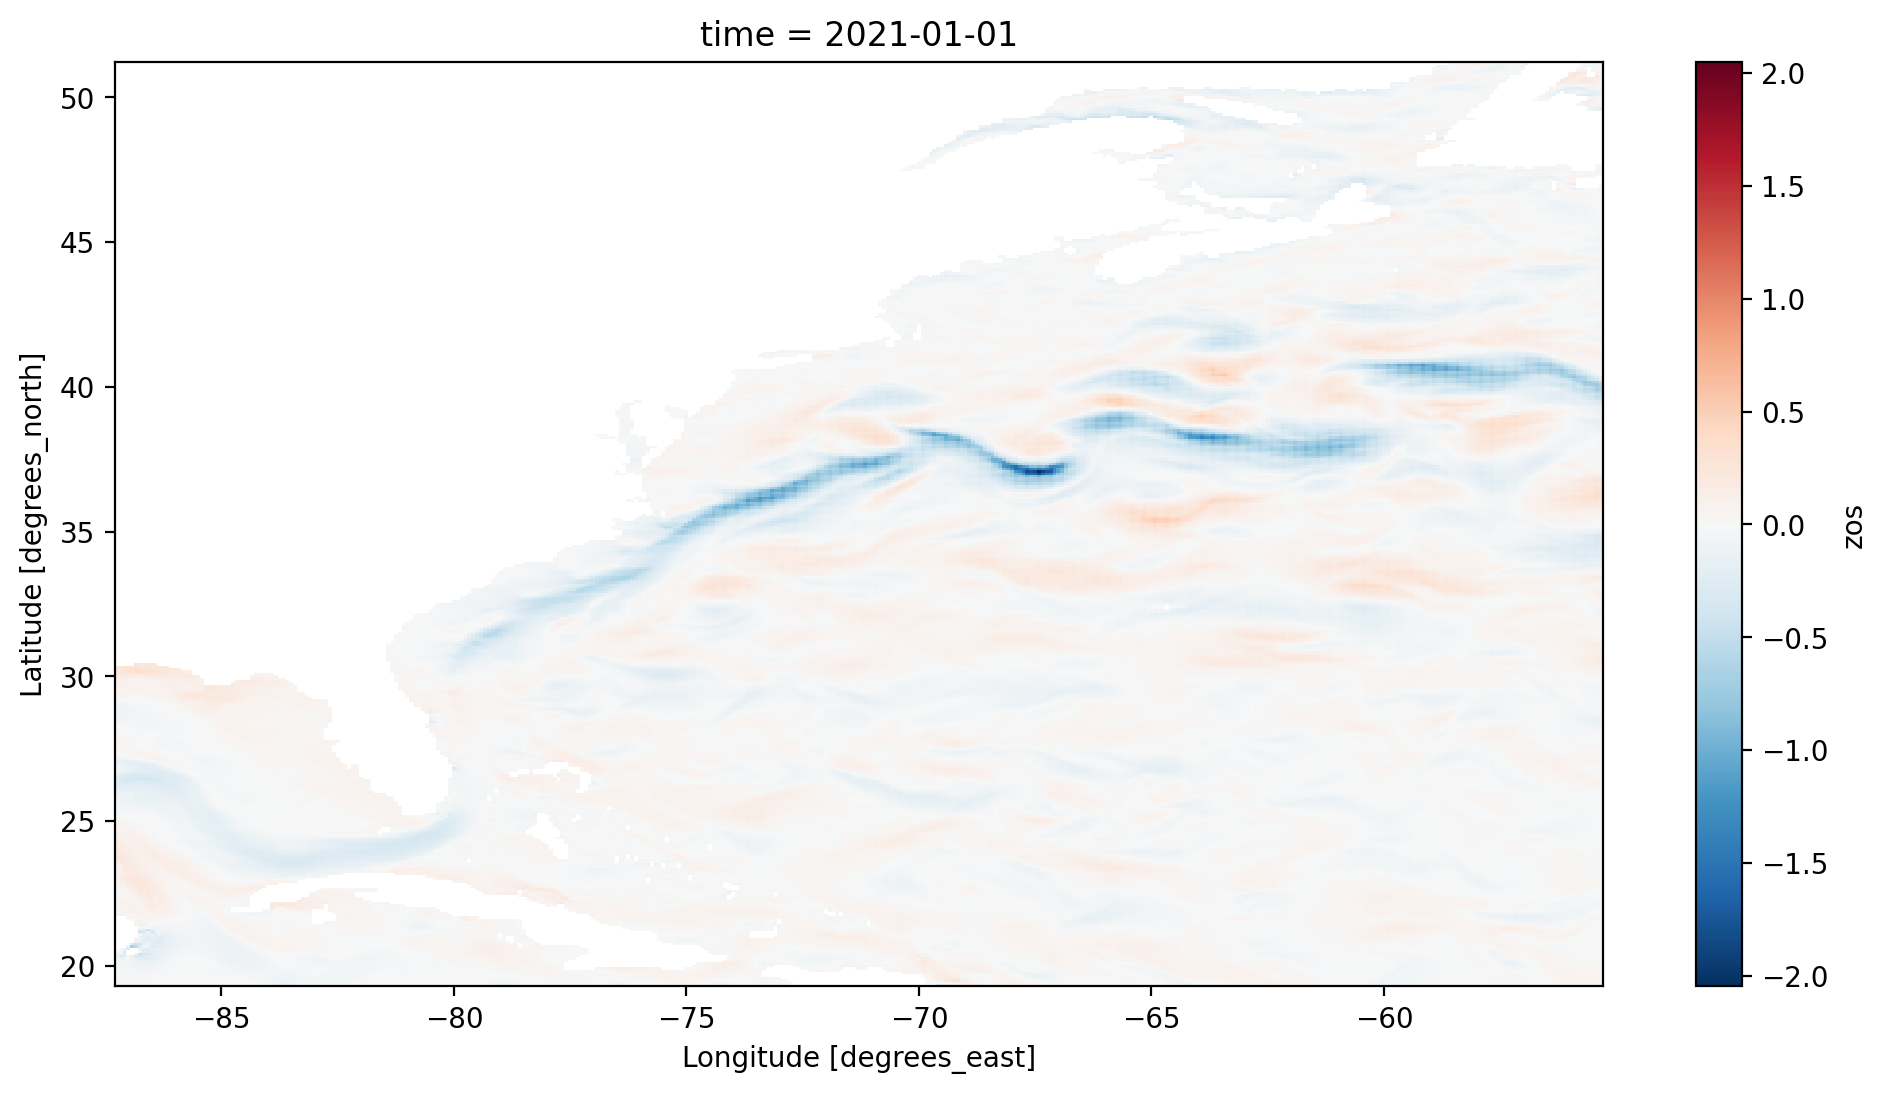

In [75]:
ug.isel(time=0).plot() # Plotting the ug values at a singular time value

In [76]:
vg_time0 = vg.isel(time=0)

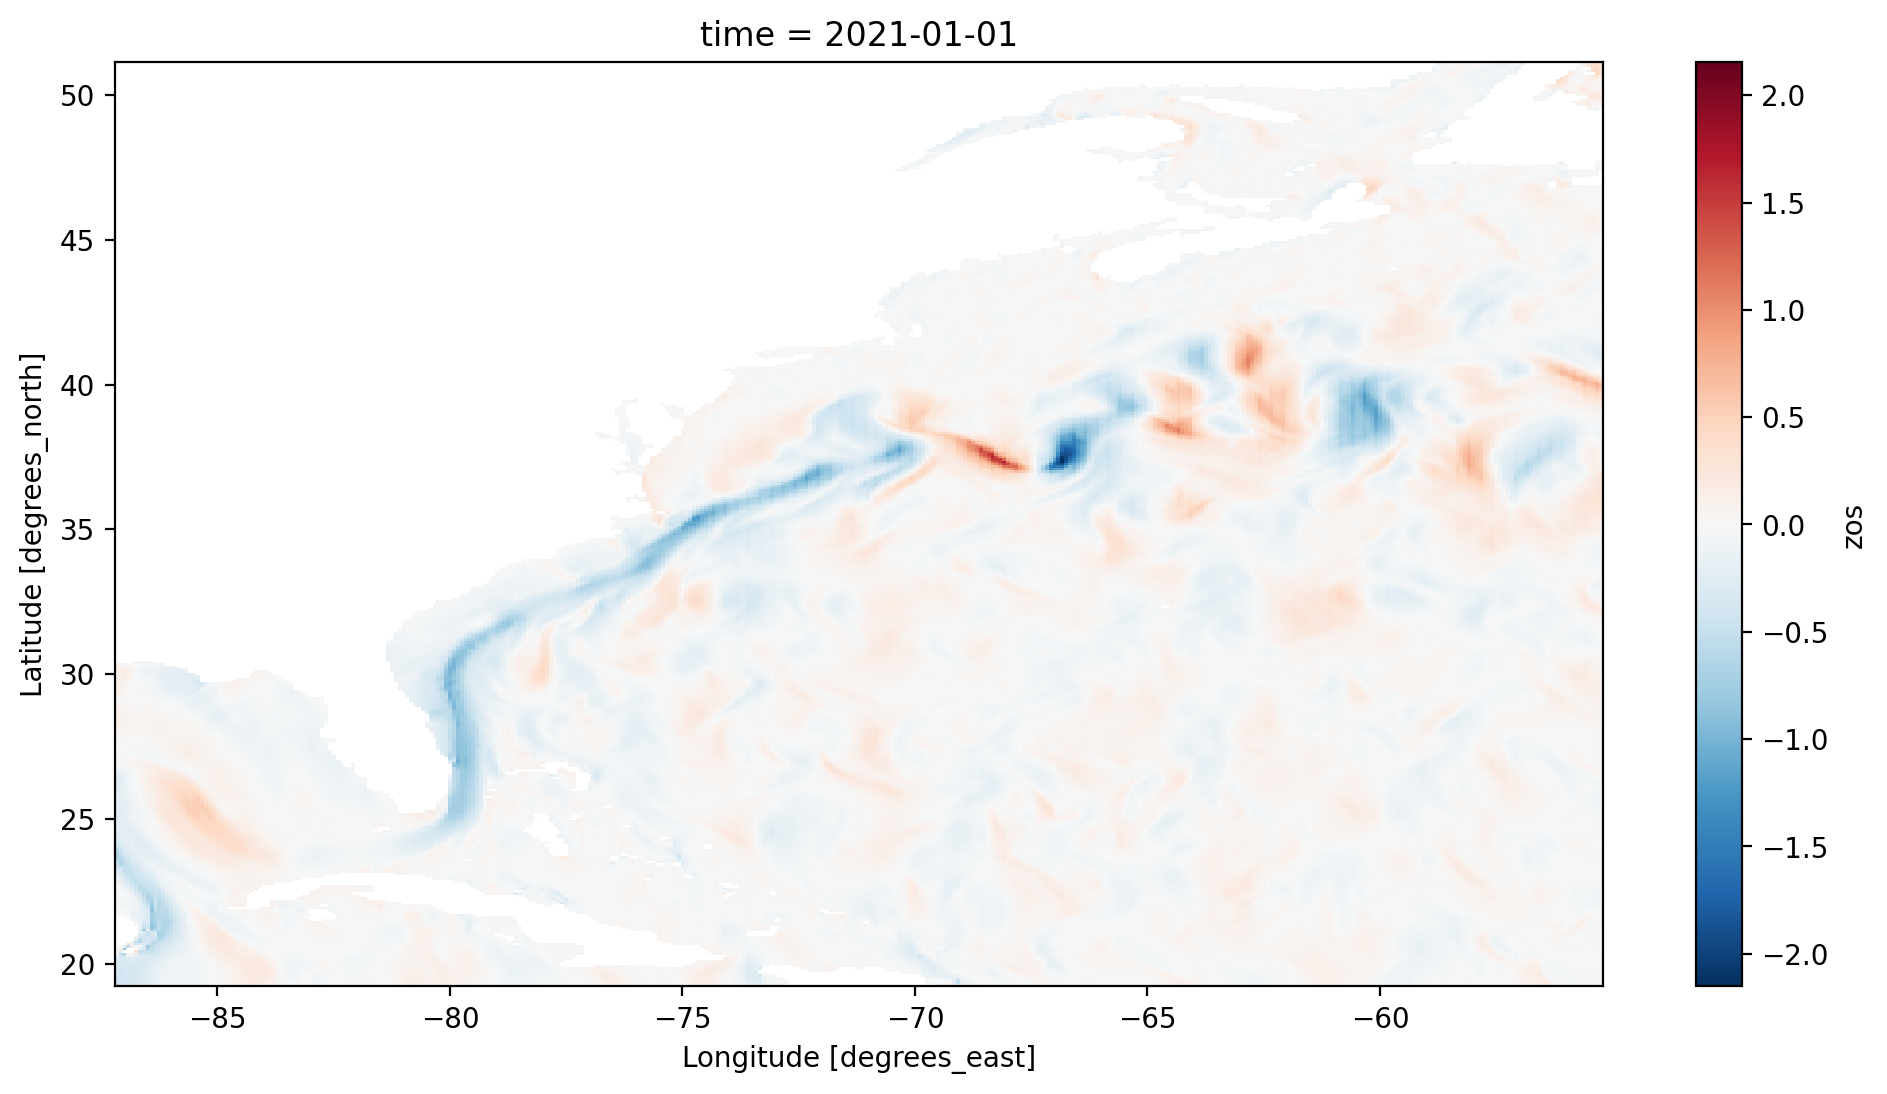

In [77]:
vg.isel(time=0).plot() # Plotting the vg values at a singular time value

In [78]:
uo_meantime = glorys_jan_mar_2021.uo.mean(dim='time')

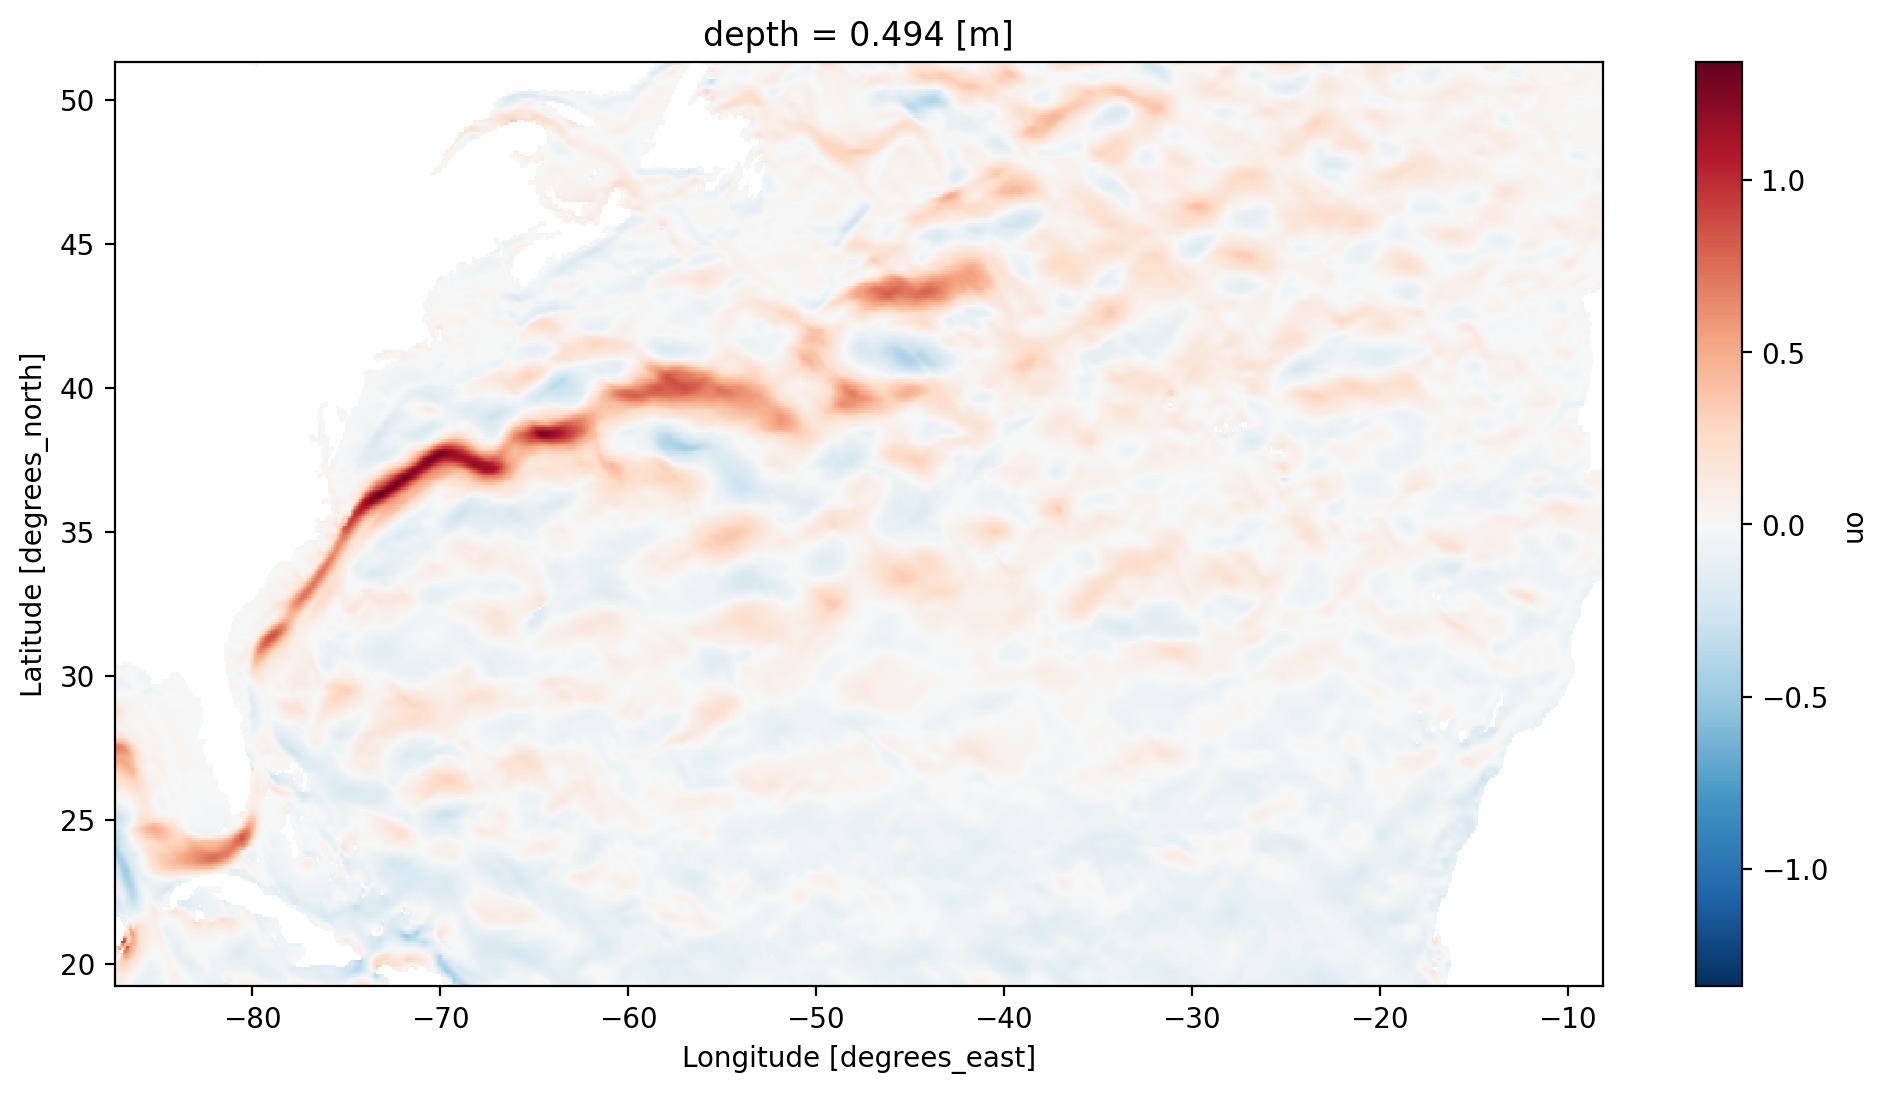

In [79]:
glorys_jan_mar_2021.uo.mean(dim='time').plot() # Plotting the uo value over the long term time mean

In [80]:
vo_meantime = glorys_jan_mar_2021.vo.mean(dim='time')

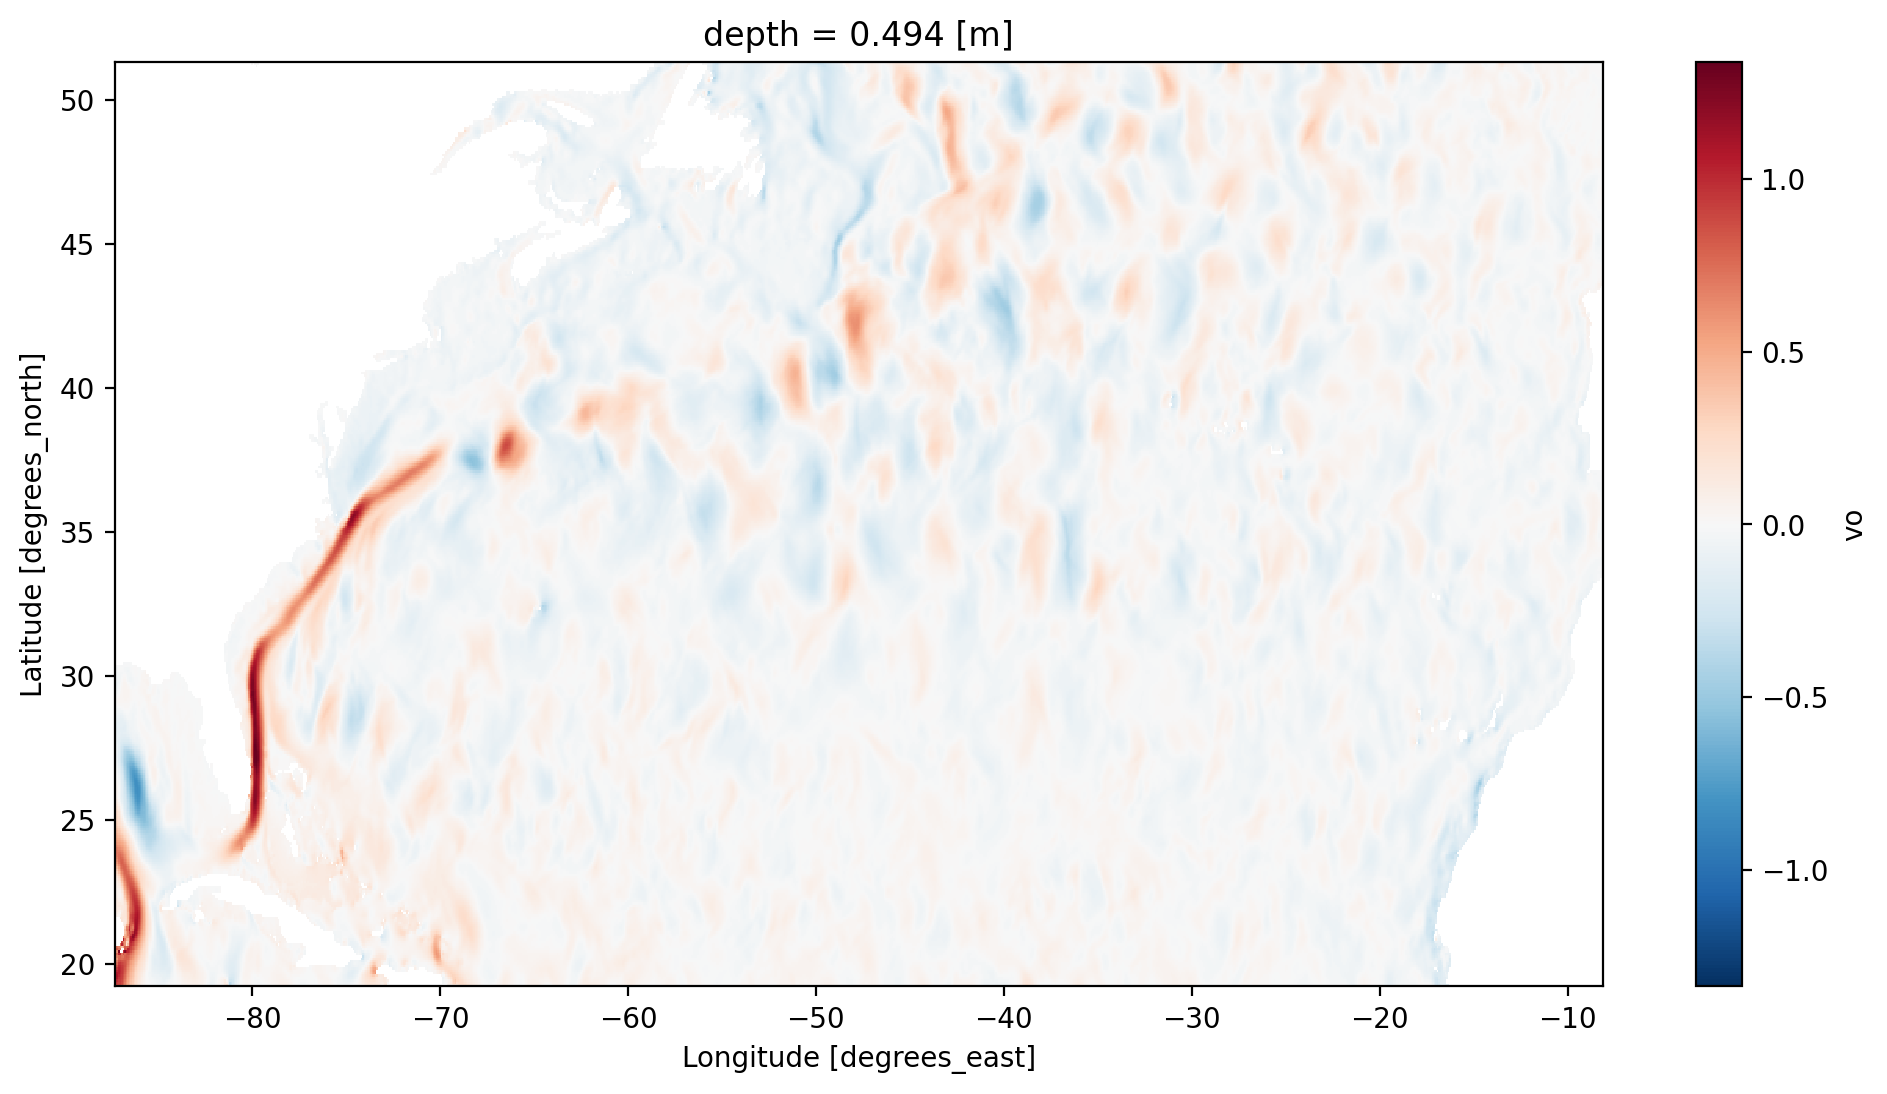

In [81]:
glorys_jan_mar_2021.vo.mean(dim='time').plot() # Plotting the vo value over the long term time mean

In [82]:
ug_meantime = ug.mean(dim='time')

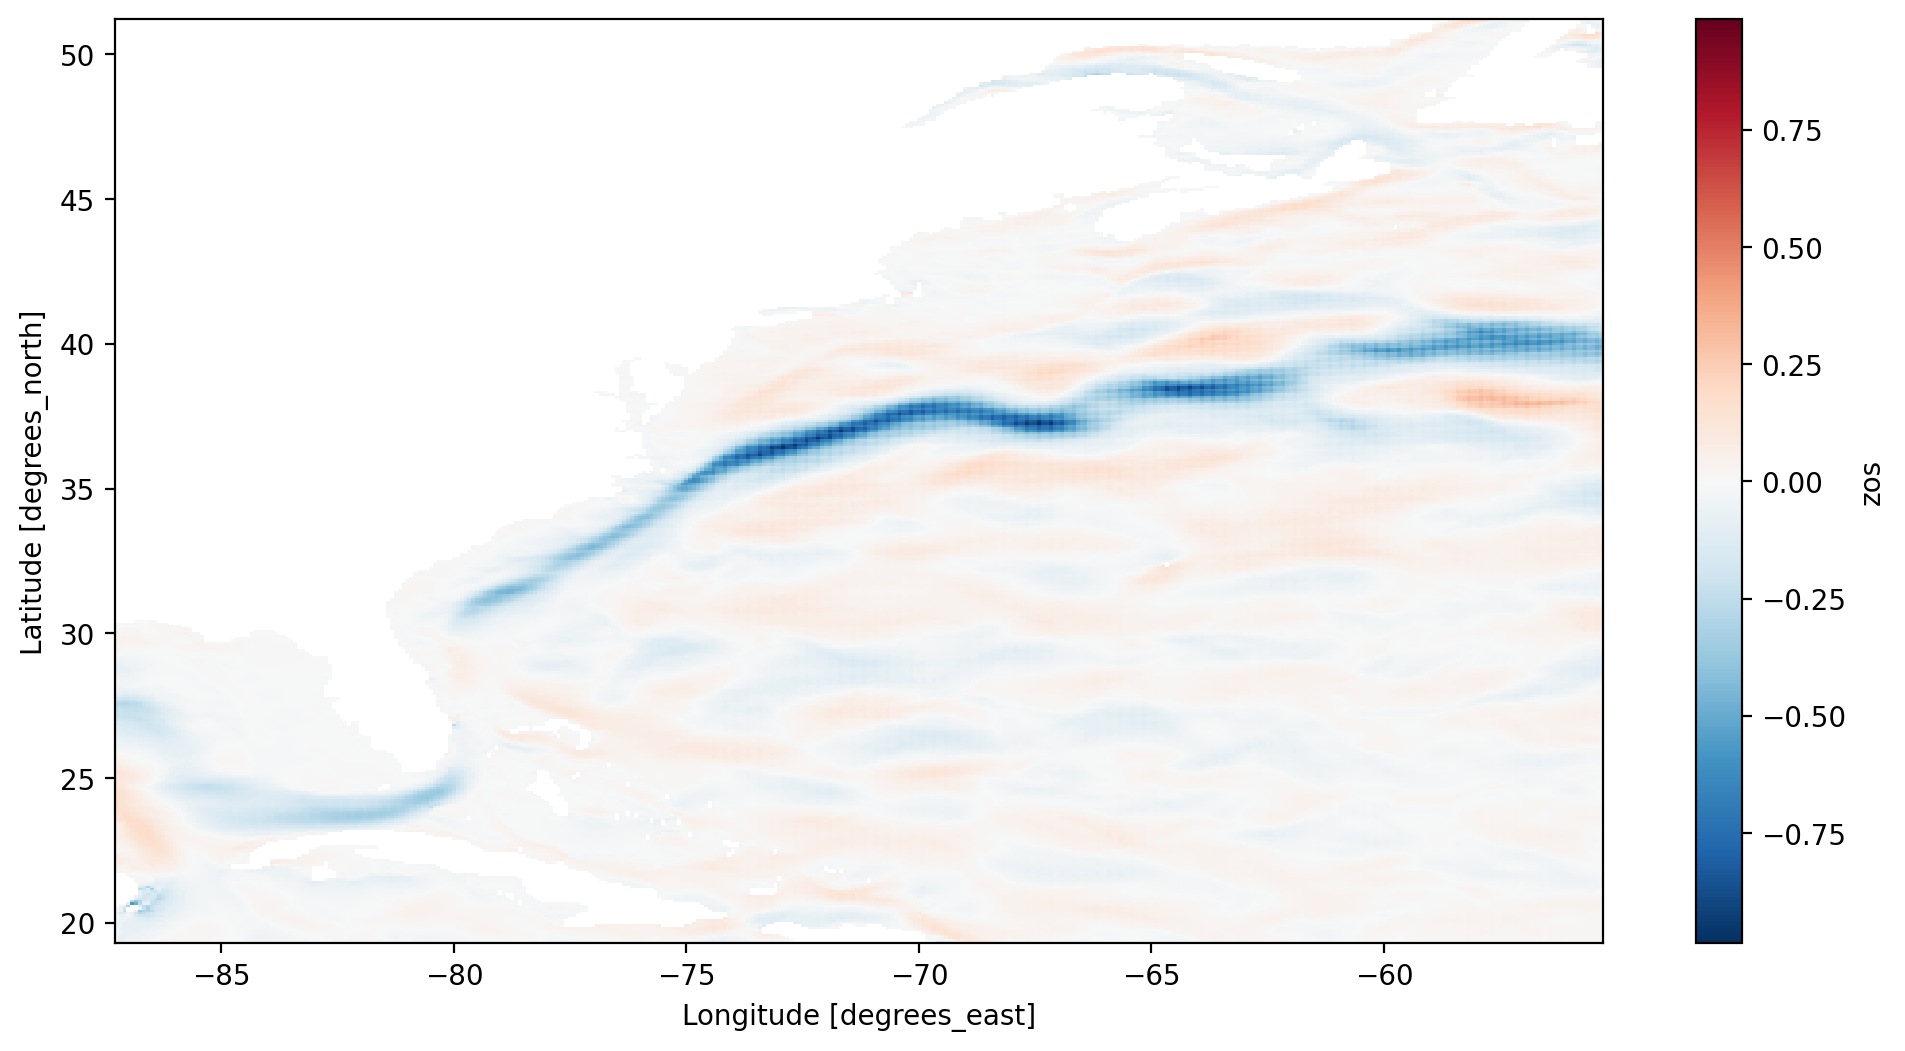

In [83]:
ug.mean(dim='time').plot() # Plotting the ug value over the long term time mean

In [84]:
vg_meantime = vg.mean(dim='time')

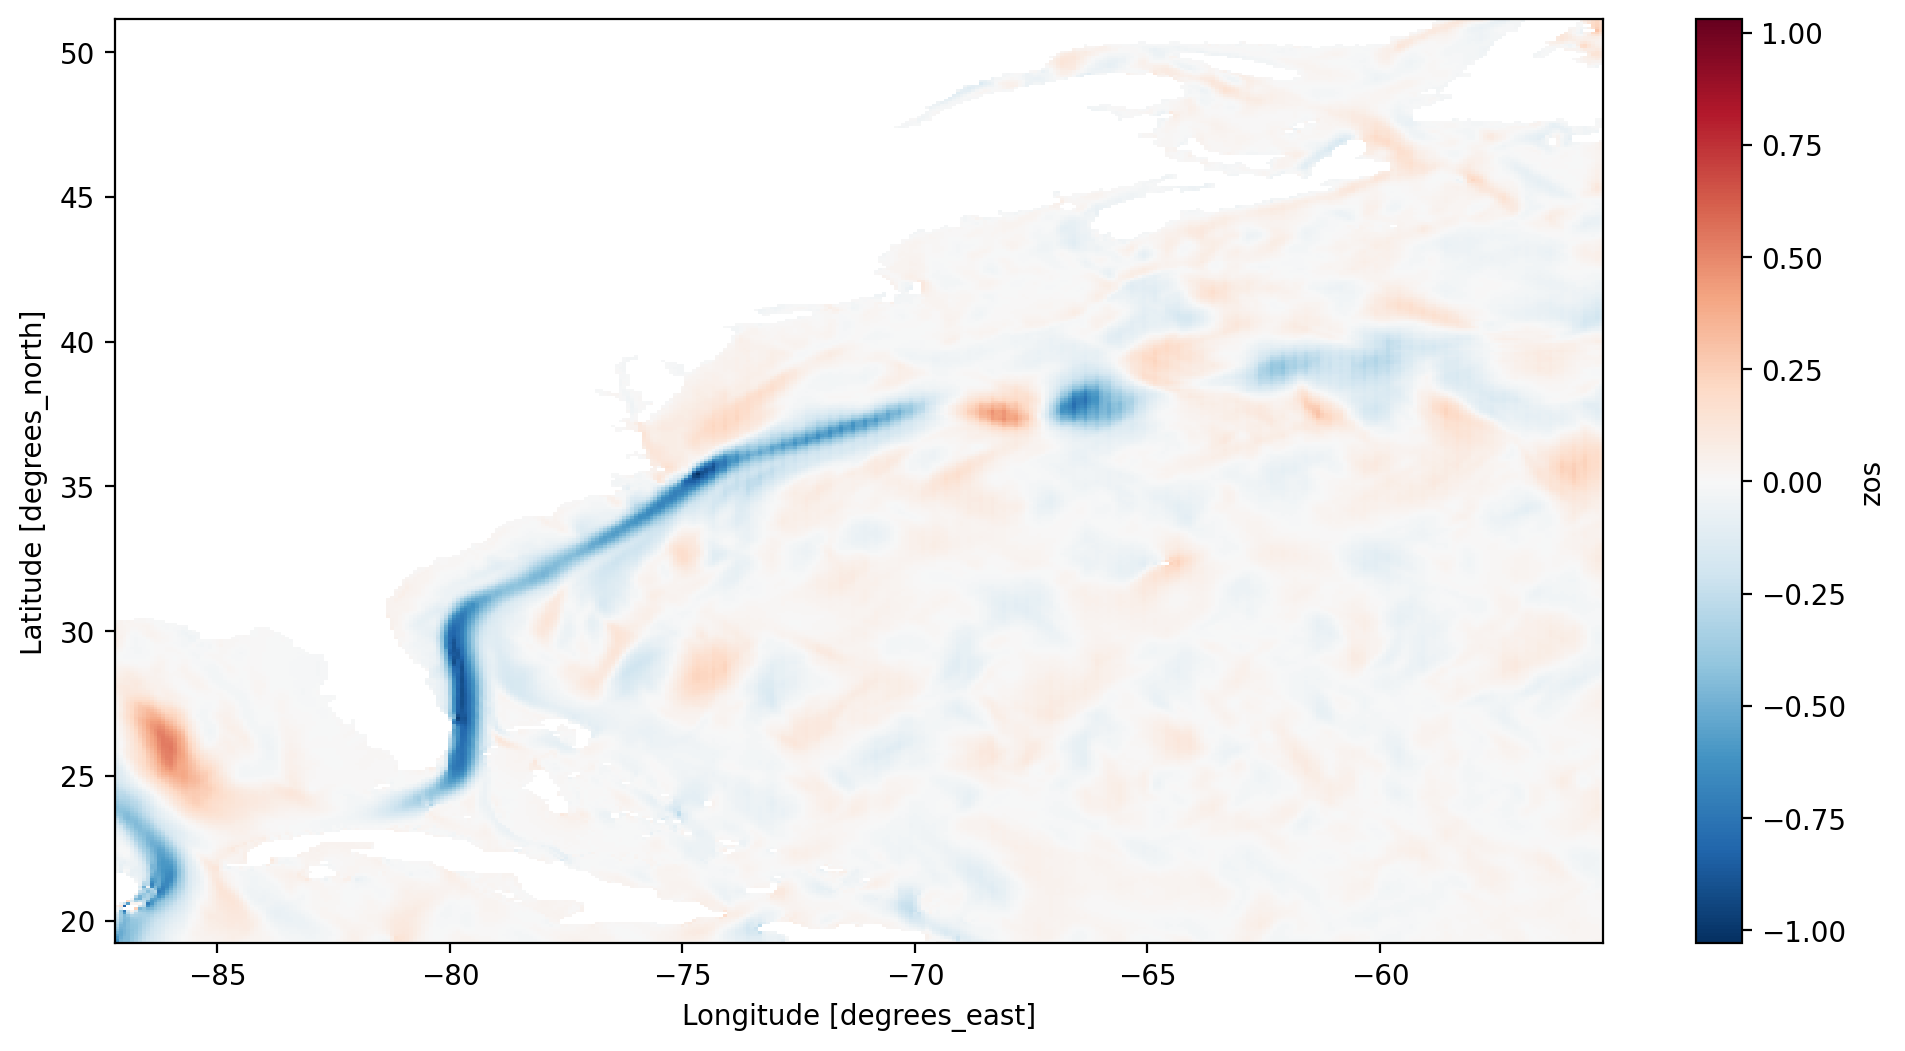

In [85]:
vg.mean(dim='time').plot() # Plotting the vg value over the long term time mean

In [89]:
uo_vo_diff_t0 = uo_time0 - vo_time0  # Calculating the difference between uo and vo

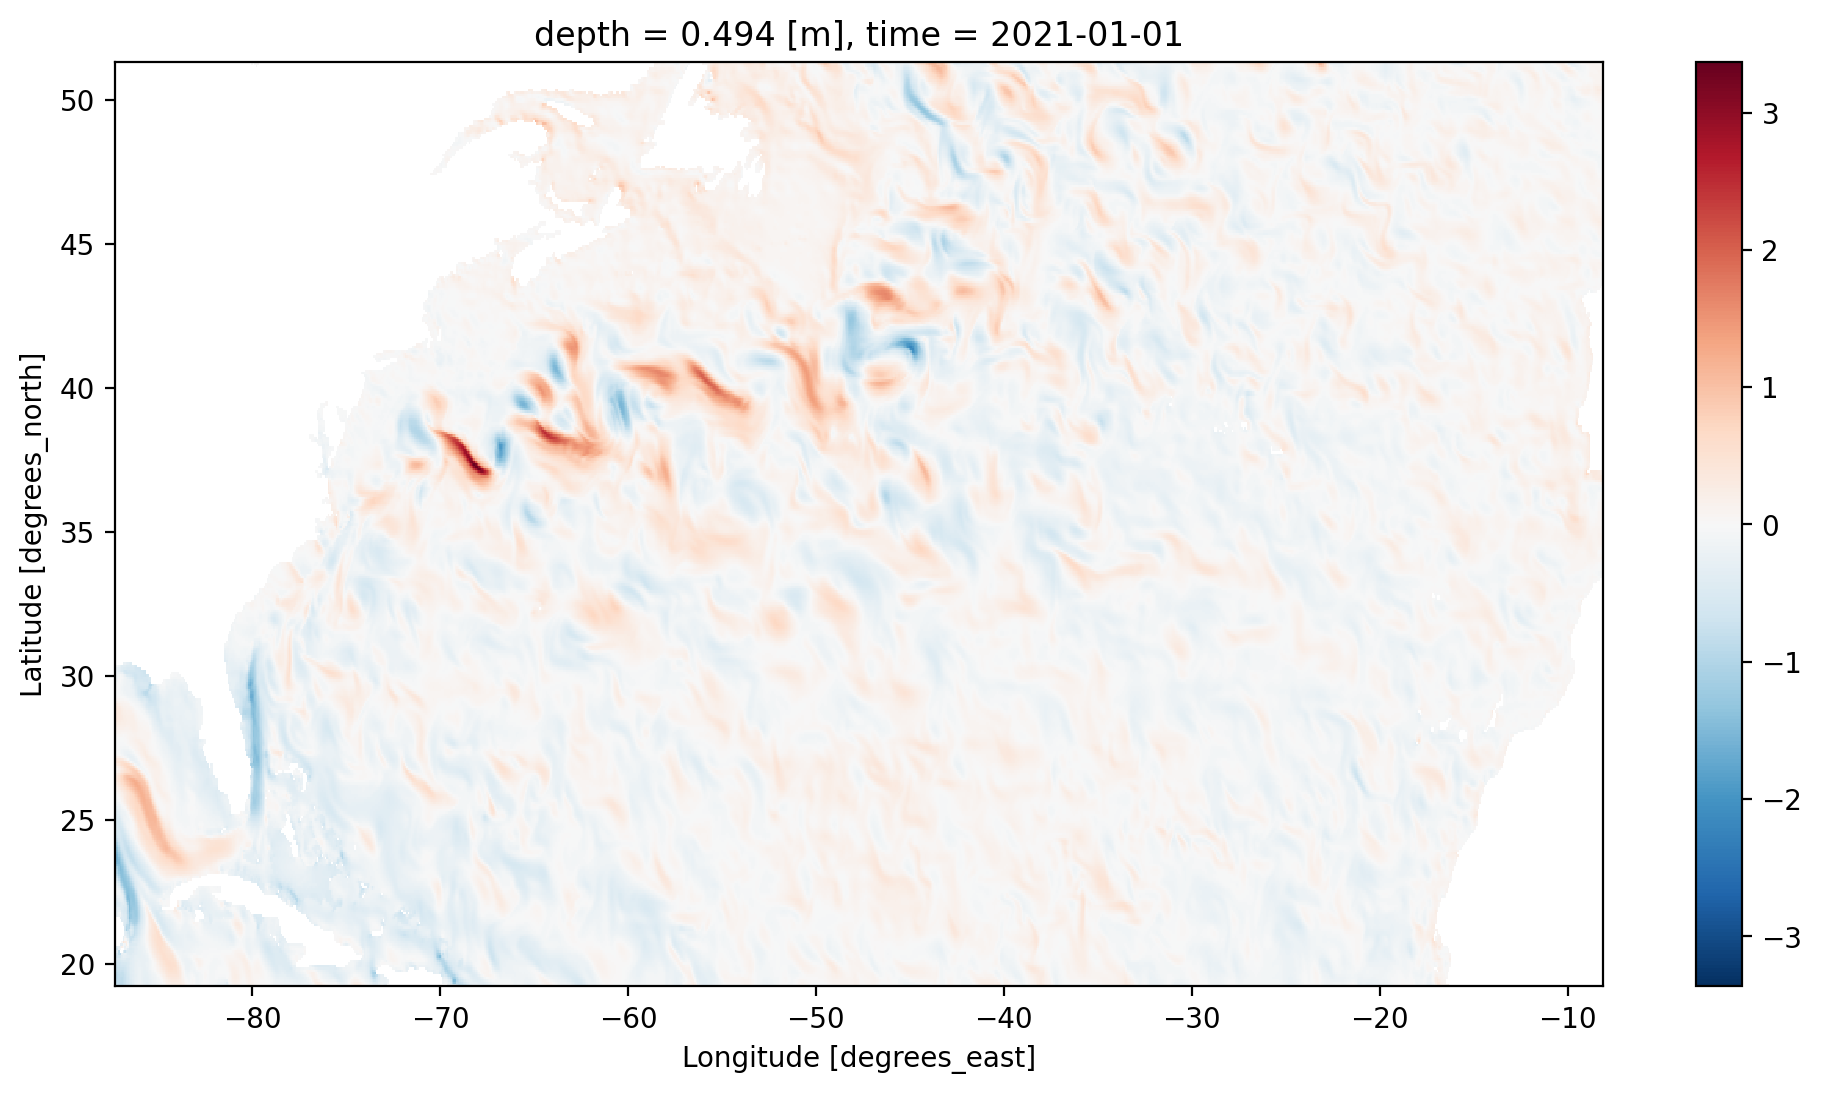

In [90]:
uo_vo_diff_t0.plot()

In [94]:
uo_ug_diff_t0 = uo_time0 - ug_time0  # The difference between uo and ug

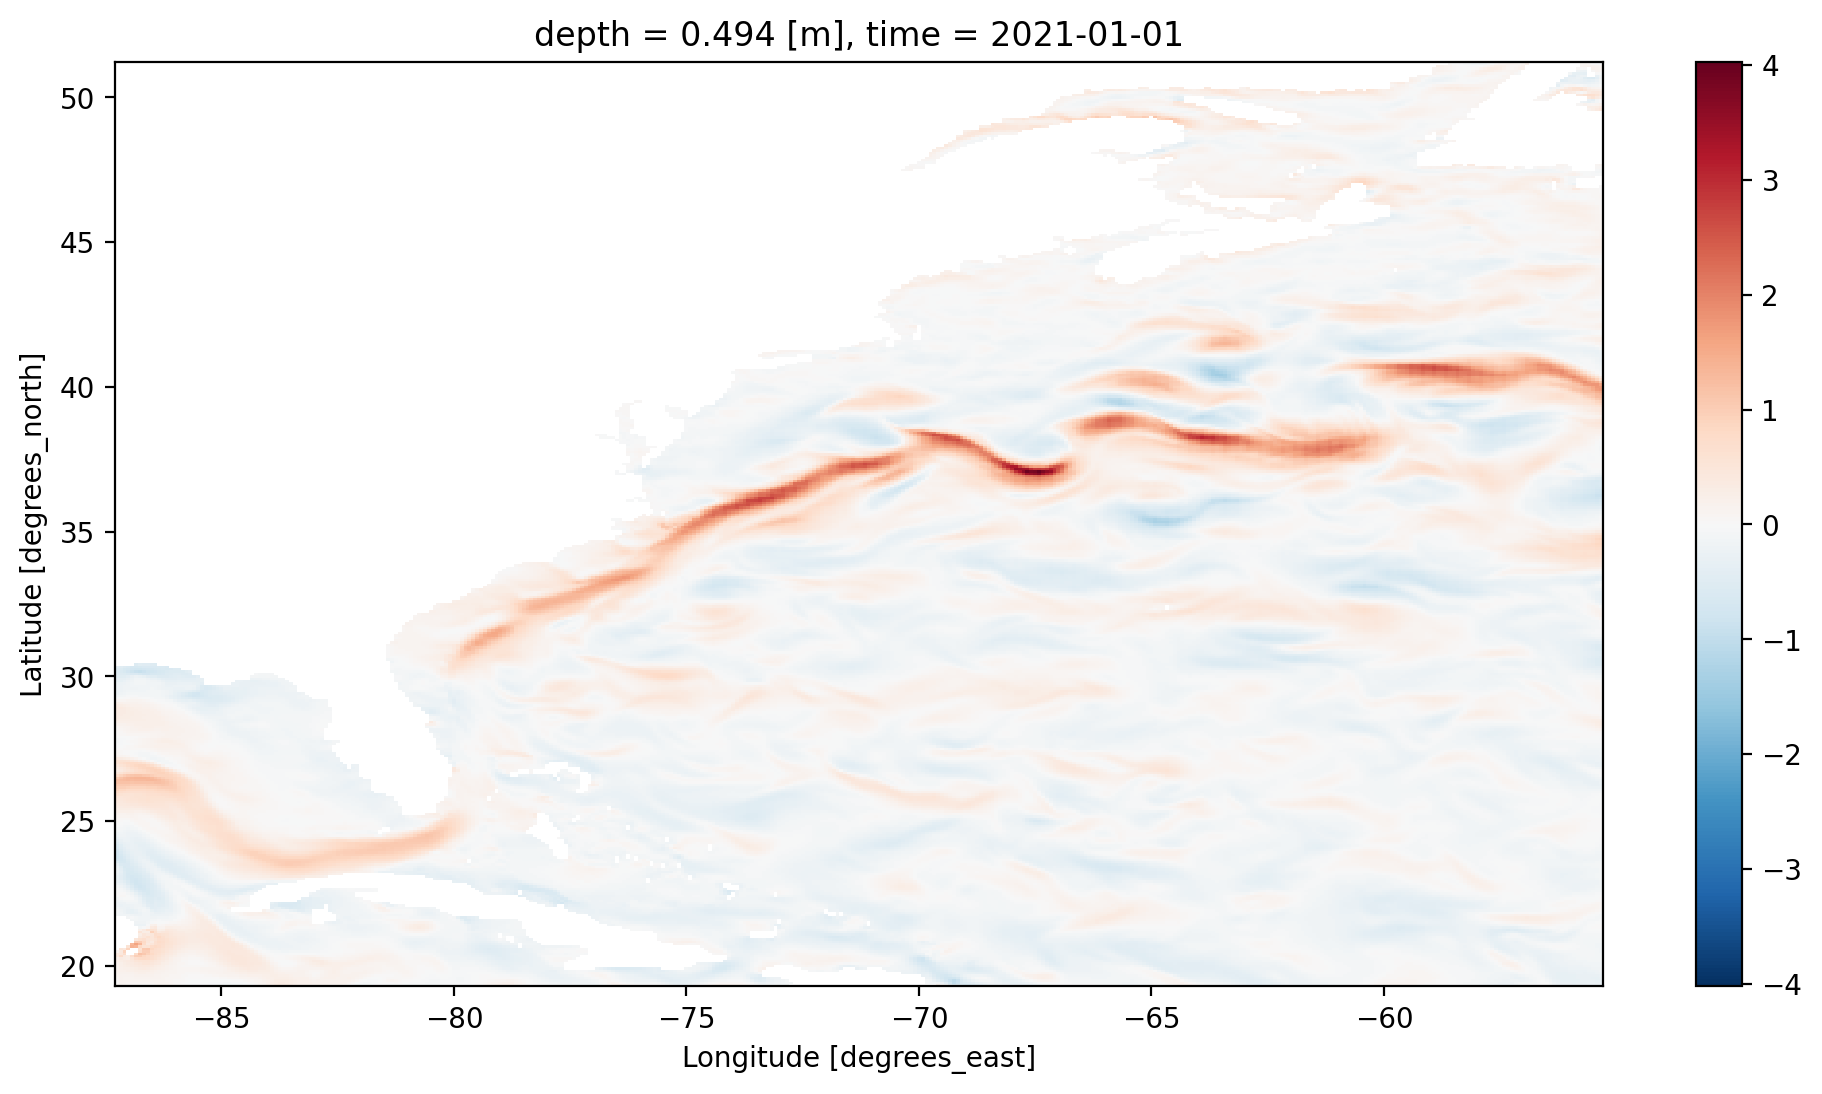

In [95]:
uo_ug_diff_t0.plot()

In [98]:
vo_vg_diff_t0 = vo_time0 - vg_time0  # The difference between vo and vg

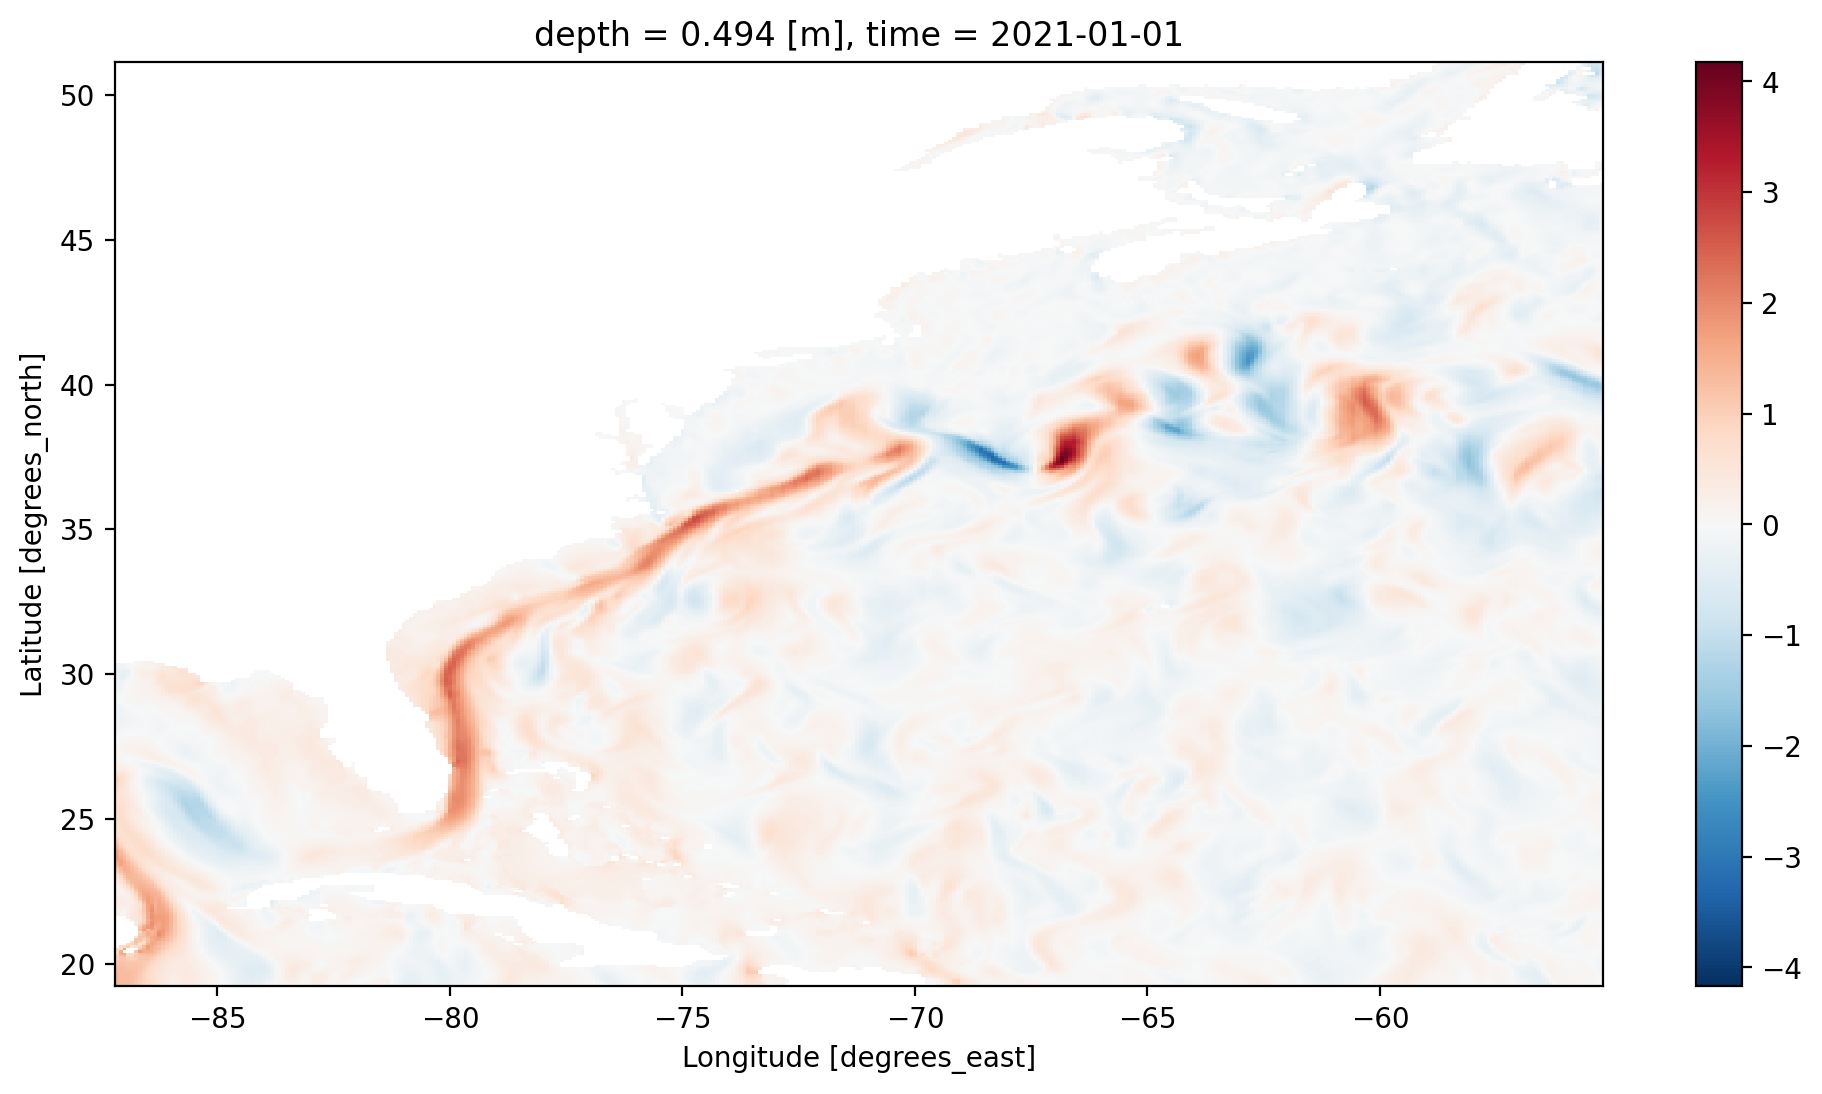

In [99]:
vo_vg_diff_t0.plot()

In [101]:
uo_ug_diff_tmean = uo_meantime - ug_meantime

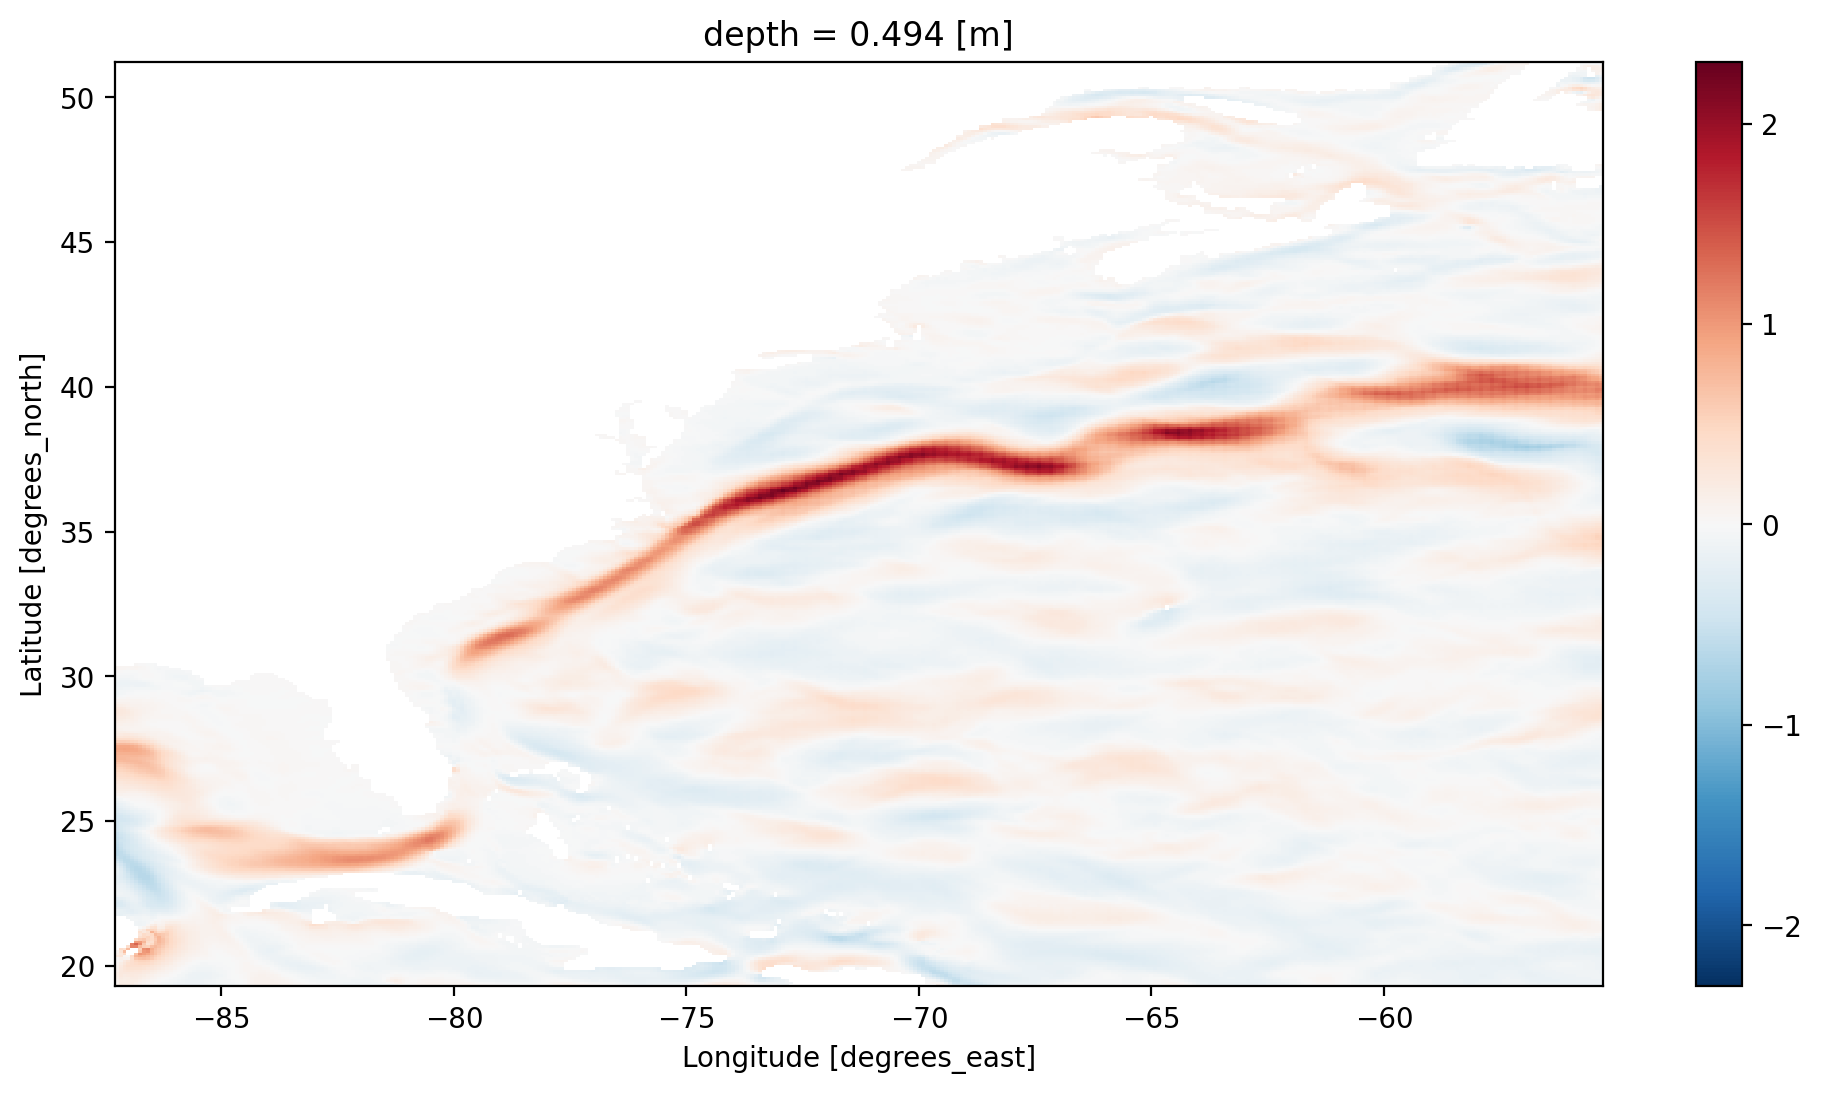

In [102]:
uo_ug_diff_tmean.plot()

In [103]:
vo_vg_diff_tmean = vo_meantime - vg_meantime

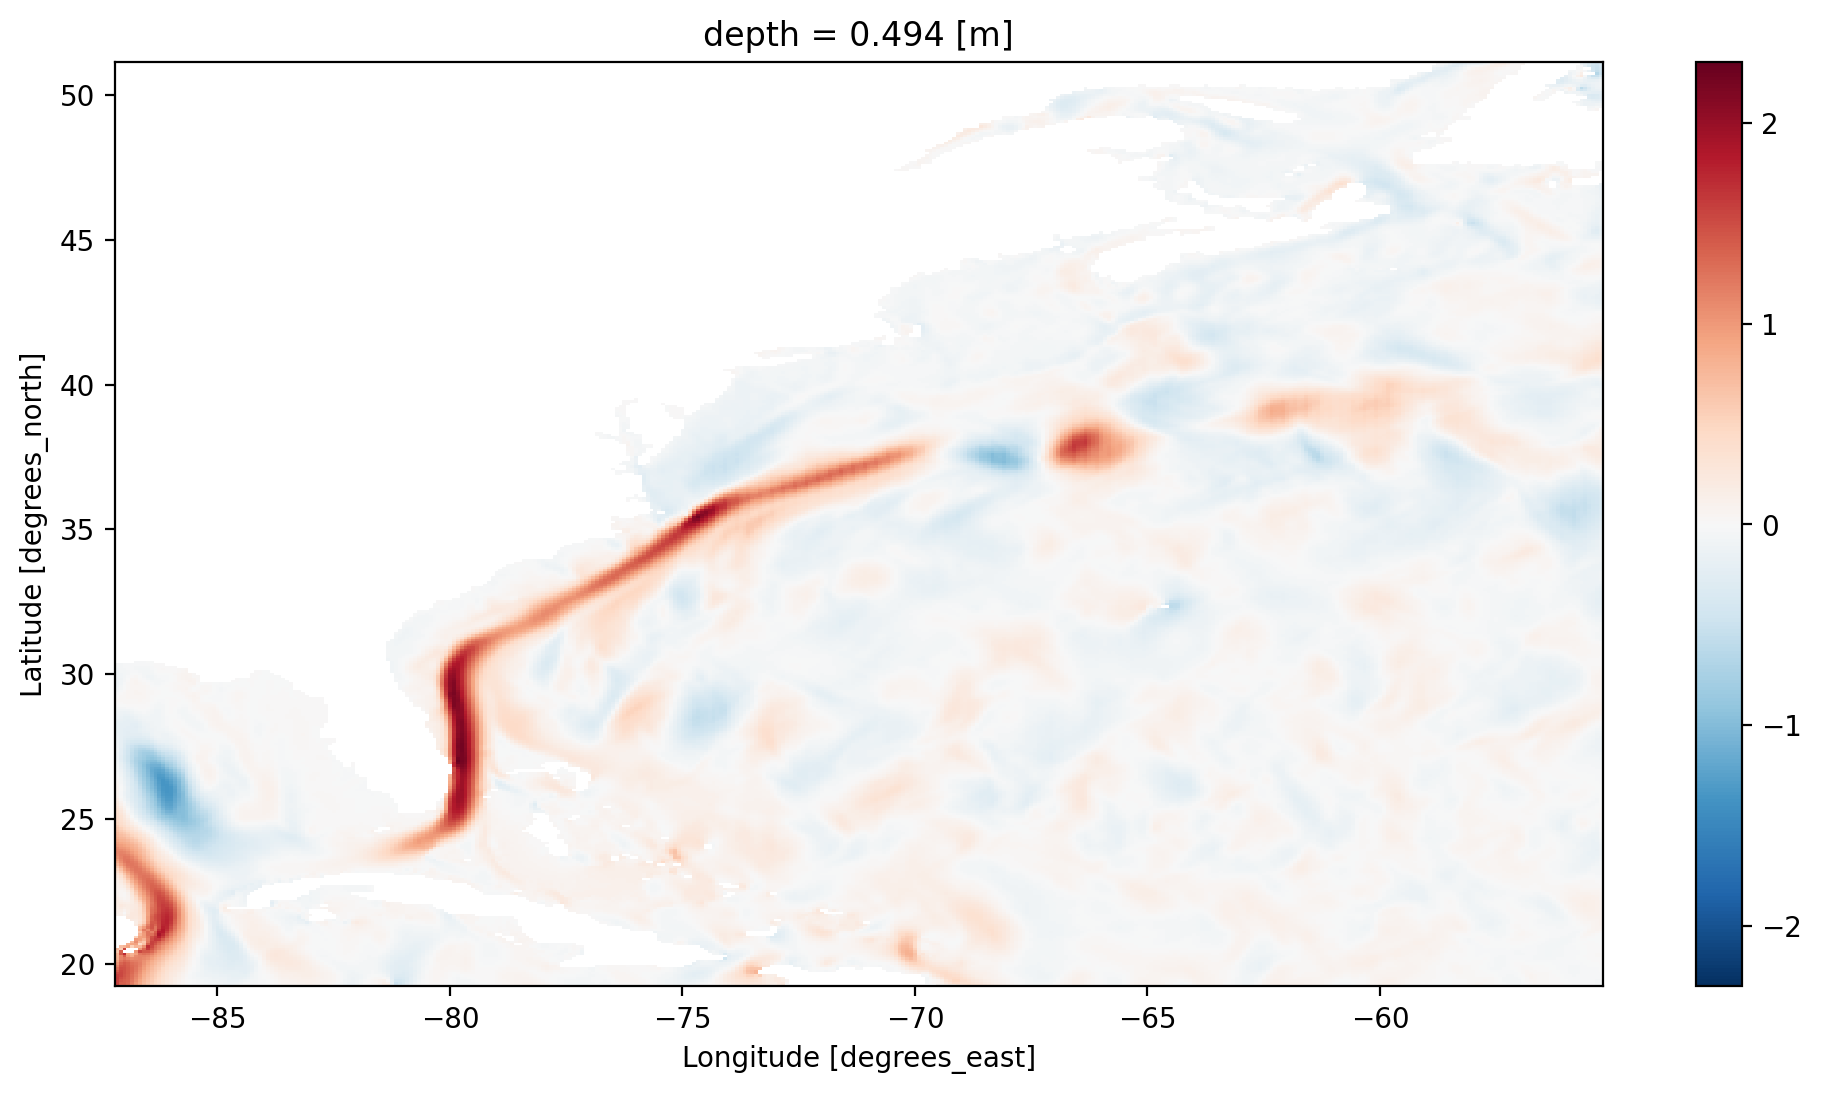

In [104]:
vo_vg_diff_tmean.plot()

In [51]:
def compute_dx_3(zos): # Defining the function "compute_dx" which requires zos as the parameter 
    
    lons = zos.coords['longitude'].values # Gathering the longitude values from the coordinate part of zos
    lats = zos.coords['latitude'].values # Gathering the latitude values from the coordinate part of zos
    
    dx_values_3 = [] # Creates an empty list to store the dx values for each latitude
    
    
    for lat in lats: # Creates a four loop over each latitude to calculate the dx values
        dx_lat = []  # Creates an empty list to store dx values for this latitude
        for i in range(len(lons) - 3):
            lon1 = lons[i]
            lon2 = lons[i + 3]
            dx = changex(lat, lon1, lon2) # Calls the function changex to use the lat, lon1, and lon2 values
            dx_lat.append(dx) # This adds the dx values to the dx_lat list
        dx_values_3.append(dx_lat) # This adds the dx_lat values to the dx_values list
    
    return np.array(dx_values_3) # Returns the dx values as an array

In [52]:
example_dx_3 = compute_dx_3(glorys_jan_mar_2021.zos)

In [53]:
example_dx_3

array([[26226.79229379, 26226.79229379, 26226.79229379, ...,
        26226.79229379, 26226.79229379, 26226.79229379],
       [26213.44475269, 26213.44475269, 26213.44475269, ...,
        26213.44475269, 26213.44475269, 26213.44475269],
       [26200.04091382, 26200.04091382, 26200.04091382, ...,
        26200.04091382, 26200.04091382, 26200.04091382],
       ...,
       [17451.10111356, 17451.10111356, 17451.10111356, ...,
        17451.10111356, 17451.10111356, 17451.10111356],
       [17419.6455574 , 17419.6455574 , 17419.6455574 , ...,
        17419.6455574 , 17419.6455574 , 17419.6455574 ],
       [17388.15357327, 17388.15357327, 17388.15357327, ...,
        17388.15357327, 17388.15357327, 17388.15357327]])

In [54]:
def compute_dy_3(zos): #Defining the function "compute_dy" which requires zos as a parameter 
    
    lons = zos.coords['longitude'].values # Gathering the longitude values from the coordinate part of zos
    lats = zos.coords['latitude'].values # Gathering the latitude values from the coordinate part of zos
    
    dy_values_3 = [] # Creates an empty list to store the dy values for each longitude
    
    for lon in lons: # Creates a four loop over each longitude to calculate the dy values
        dy_lon = []  # Creates a list to store the dy values for this longitude
        for i in range(len(lats) - 3):
            lat1 = lats[i]
            lat2 = lats[i + 3]
            dy = changey(lat1, lat2) # Calls the function changey to use the lat1 and lat2 values
            dy_lon.append(dy) # This adds the dy values to the dy_lon list
        dy_values_3.append(dy_lon) # This adds the dy_lon values to the dy_values list
    
    return np.array(dy_values_3) # Returns the dy values as an array

In [55]:
example_dy_3 = compute_dy_3(glorys_jan_mar_2021.zos) # Calling the function above and inputing the zos xarray

In [56]:
example_dy_3

array([[27780., 27780., 27780., ..., 27780., 27780., 27780.],
       [27780., 27780., 27780., ..., 27780., 27780., 27780.],
       [27780., 27780., 27780., ..., 27780., 27780., 27780.],
       ...,
       [27780., 27780., 27780., ..., 27780., 27780., 27780.],
       [27780., 27780., 27780., ..., 27780., 27780., 27780.],
       [27780., 27780., 27780., ..., 27780., 27780., 27780.]])

In [57]:
zos = glorys_jan_mar_2021.zos.isel(time=20).load()

In [58]:
zos3 = xr.DataArray(glorys_jan_mar_2021.zos.mean(dim='time'))  # Defining zos and exluding the time by taking the mean

zos3_long_sliced = zos.isel(longitude=slice(0, 382))  # Slicing the zos data to match coordinate dimension of the latitude coordinates since the dimensions of longitude are larger
zos3_long_sliced = zos.isel(latitude=slice(0, 384))  # Slicing the zos data to match the coordinate dimension

dx_values_3 = compute_dx_3(zos_sliced) # Computing dx_3 with the sliced data using the compute_dx_3 function
dy_values_3 = compute_dy_3(zos_sliced) # Computing dy_3 with the sliced data using the compute_dy_3 function

dx_xr_3 = xr.DataArray(dx_values_3, # This is defining the xarrays with the coordinates as the sliced values
                     coords=[zos_sliced.coords['latitude'], zos_sliced.coords['longitude'][1:-2]], 
                     dims=["latitude", "longitude"])

dy_xr_3 = xr.DataArray(dy_values_3, 
                     coords=[zos_sliced.coords['latitude'][:-1], zos_sliced.coords['longitude'][1:-1]], 
                     dims=["latitude", "longitude"])

In [59]:
dx_values_3.shape

(385, 381)

In [100]:
dh_lon_3 = h.diff('longitude') # Finding the dh for the longitudes
dx_xr_3 = dx_values_3[385, 382-1] # Slicing the dx values in the proper dimensions 
grad_lon_3 = dh_lon / dx_xr_3 # Finding the dh/dx gradient

# Still working on figuring this out

IndexError: index 385 is out of bounds for axis 0 with size 385

In [ ]:
dh_lon_31 = (h.mean(dim='time').isel(longitude=slice(2, -0)) - h.mean(dim='time').isel(longitude=slice(0, -2))) / 2
dh_lon_3 = dh_lon_31.isel(longitude=slice(1, -1))
dx_sliced = dx_values_3[:, 2:-2]
grad_lon_3 = dh_lon_3 / dx_sliced

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(zos.longitude, zos.latitude, zos, vmin=-1, vmax=1, \
          cmap=plt.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
ax.set_facecolor('#cccccc')
ax.set_title('SSH [m]')
axins1 = inset_axes(ax, width="40%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()

In [ ]:
# sample surface velocities
ss_u = glorys_jan_mar_2021.isel(time=20).uo.isel(depth=0).load()
ss_v = glorys_jan_mar_2021.isel(time=20).vo.isel(depth=0).load()
speed = 0.5*(ss_u**2 + ss_v**2)

In [ ]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(ss_u.longitude, ss_u.latitude, speed, norm=LogNorm(vmin=0.01, vmax=1), \
          cmap=plt.get_cmap('viridis',10),transform=ccrs.PlateCarree())
ax.set_title(r'Surface Kinetic Energy [m$^2$s$^{-2}$]')
ax.set_facecolor('#cccccc')
axins1 = inset_axes(ax, width="30%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()